<a href="https://colab.research.google.com/github/msmccann10/PP-board-game-industry-modeling/blob/main/Board_Game_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Board Game Prediction
- **Author:** Michael McCann
- **Date:** 01 APR 2022

## Imports

In [6]:
!pip install xgboost

     -------------------------------------- 125.4/125.4 MB 4.6 MB/s eta 0:00:00


In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn import set_config
set_config(display='diagram')

## Functions

### OHE Reversing Function

In [2]:
## create OHE reversing function...
def ohe_reverse(row, names):
    # Change the row into a np.array
    cat = np.array(row) 
    # Add spaces and commas into the name array for spacing..
    names = [' ' + i + ',' for i in names]
    return ''.join(np.repeat(names, cat))

### Custom Make Longer Function

In [3]:
## Create A custome longer function...
def make_longer(data, col):
    # fix output - blanks
    bad_rows = data[data['ohe'] == ''].index
    data.drop(bad_rows, inplace = True)

    data['ohe'] = data['ohe'].str.lstrip()
    data['ohe'] = data['ohe'].str[:-1]

    # Stack the result 
    val = pd.concat([data['BGGId'],
                data['ohe'].str.split(',', expand = True)],
                axis = 1)

    melt = pd.melt(val, id_vars=['BGGId'])
    long_df = melt[melt.value.notnull()].sort_values('BGGId').reset_index(drop=True).rename(columns={'value':col}).drop(columns = 'variable')
    long_df[col] = long_df[col].str.lstrip()
    data.drop(columns = 'ohe', inplace = True)
    return long_df

### Distribution Graphing Function

In [4]:
## Create Functions for graphing Distribution of major features:
# Feature Distribution Graphs
def feature_dist(data, col, topX = 20, binW = 10):

    values = data[col].value_counts()

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,7))
    sns.barplot(x = values.head(topX),y = values.head(topX).index, color = 'Green', ax = axes[0])
    axes[0].set_xlabel('Number of Games', weight = 'semibold', fontsize = 14)
    axes[0].set_ylabel(f'{col}s', weight = 'semibold', fontsize = 14)
    axes[0].set_title(f'Most Prolific {col}s (Top {topX})', weight = 'semibold', fontsize = 16)
    axes[0].set_axisbelow(True)
    axes[0].grid(alpha = .4)
    sns.histplot(values, binwidth=binW, binrange=(0,150), color = '#127ead', ax=axes[1])
    axes[1].set_xlim(0,150)
    axes[1].set_xlabel(f'Number of Games (bin width = {binW})', weight = 'semibold', fontsize = 14)
    axes[1].set_ylabel(f'{col}s per Bin', weight = 'semibold', fontsize = 14)
    axes[1].set_title(f"{col}s Distribution", weight = 'semibold', fontsize = 16)
    axes[1].set_axisbelow(True)
    plt.grid(alpha = .4)
    plt.tight_layout()
    plt.show();

# Feature Distribution Graphs 2
def feature_dist2(data, col, topX = 20):
    values = data[col].value_counts()

    fig, ax = plt.subplots(figsize = (18,6))   
    sns.barplot(y = values.head(topX),x = values.head(topX).index, color = '#A90200', alpha = .9)
    plt.xlabel(f'{col}s (Top {topX})', weight = 'semibold', fontsize = 14)
    plt.ylabel('Number of Games', weight = 'semibold', fontsize = 14)
    plt.title(f"Top {col}s", weight = 'semibold', fontsize = 18)
    ax.set_axisbelow(True)
    plt.grid(alpha = .4)
    plt.xticks(rotation=60, ha = "right", rotation_mode = 'anchor')
    plt.tight_layout()
    plt.show();

### Top/Bottom Split Function

In [5]:
## Create Function to Split artist/designer/producers by top/bottom percent:
def topbot_split(data, data5k, col, top_col = 'top', bot_col = 'bot', split_perc = 20,):
    temp = pd.merge(data, bggid, how = 'right', on = 'BGGId')
    temp.fillna(value = 0, inplace = True)

    # denominator for split value for loop (below)
    denom = data5k[col].value_counts().sum()
    head_val = 0

    # find split value
    for i in range(0,50):
        if math.floor(data5k[col].value_counts().head(i).sum()/denom * 100) == split_perc:
            head_val = i
            break
            
    # Use above value to create mask
    mask =list(data5k[col].value_counts().head(head_val).index)

    # Apply to the ohe DF
    temp_top = temp[mask] #create a top 20% df
    temp_bot = temp.drop(columns = mask)#create a bottom 20% df

    temp_top[top_col] = temp_top.max(axis = 1)
    temp_bot[bot_col] = temp_bot.drop(columns = 'BGGId').max(axis = 1)
    temp_topbot = pd.concat([temp_bot['BGGId'], temp_top[top_col], temp_bot[bot_col]], axis = 1)
    return temp_topbot

### Model Performance Function - Regression

In [6]:
regressperformance = pd.DataFrame(columns = ['model name', 'R-Squared (R2)',
                                           'Mean Absolute Error (MAE)', 
                                           'Mean Squared Error (MSE)', 
                                           'Root Mean Squared Error (RMSE)'])

## Create Function to evaluate regression models
from numpy.ma.core import sqrt
def model_eval(model, model_name, X_train, X_test, y_train, y_test):
    # Get Preds
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Get Metrics
    r2_train = round(r2_score(y_train, train_preds), 3)
    r2_test = round(r2_score(y_test, test_preds), 3)
    mae_train = round(mean_absolute_error(y_train, train_preds), 3)
    mae_test = round(mean_absolute_error(y_test, test_preds), 3)
    mse_train = round(mean_squared_error(y_train, train_preds), 3)
    mse_test = round(mean_squared_error(y_test, test_preds), 3)
    rmse_train = round(np.sqrt(mean_squared_error(y_train, train_preds)), 3)
    rmse_test = round(np.sqrt(mean_squared_error(y_test, test_preds)), 3)

    # Save into Display
    temp_df = pd.DataFrame({'model': [model_name, model_name], 'Type': ['Training', 'Testing'],
                            'R2': [r2_train, r2_test], 'MAE': [mae_train, mae_test],
                            'MSE': [mse_train, mse_test], 'RMSE': [rmse_train, rmse_test]})

    display(temp_df)

    metrics = {'model name': model_name, 'R-Squared (R2)': r2_test, 
               'Mean Absolute Error (MAE)': mae_test, 
               'Mean Squared Error (MSE)': mse_test, 
               'Root Mean Squared Error (RMSE)': rmse_test}

    return metrics

### Model Performance Function - Classification

In [7]:
classperformance = pd.DataFrame(columns = ['model name', 'accuracy', 'roc_auc', 
                                           'precision_min', 'recall_min', 'f1-score_min', 
                                           'precision_maj', 'recall_maj', 'f1-score_maj'])

def class_eval(model, model_name, X_train, X_test, y_train, y_test):
    # Get Preds
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(classification_report(y_test, test_preds))

    fig, ax = plt.subplots(ncols=2, nrows = 1, figsize=(10,6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
                                          ax=ax[0])
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
                                          normalize='true', ax=ax[1])
    
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    clf_rep = precision_recall_fscore_support(y_test, test_preds)
    metrics = {'model name': model_name, 'accuracy': test_score, 'roc_auc': roc_auc,
               'precision_min': clf_rep[0][1], 'recall_min': clf_rep[1][1], 
               'f1-score_min': clf_rep[2][1], 'precision_maj': clf_rep[0][0], 
               'recall_maj': clf_rep[1][0], 'f1-score_maj': clf_rep[2][0]}

    return metrics

# Data Cleaning
The data for this project comes from multiple separate dataframes so I will work through these one at a time prior to merging them into a larger dataframe for ML.

## Rank DF

In [9]:
# Import Data
rank_df = pd.read_csv('data/Rankings/rankings by id.csv')
rank_df.head()

,BoardGameRank,2018-10-06,2018-10-13,2018-10-20,2018-10-27,2018-11-03,2018-11-09,2018-11-17,2018-11-24,2018-12-01,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
0,1,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,...,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0
1,2,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,...,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0
2,3,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,...,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0
3,4,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,...,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0
4,5,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,...,233078.0,233078.0,233078.0,233078.0,291457.0,233078.0,291457.0,291457.0,291457.0,291457.0


Dataset Creator claims to have increased the numbers of ranks scraped from 2000 to 5000 starting September 7, 2019. The below code confirms an increase, however, similar to previous dates the number is actually less than the intended 5000. 


In [10]:
# Confirm point at which the pull increases.
print(f'Number of non-null values on August 31, 2019: {5015 - (rank_df["2019-08-31"].isna().sum())} ')
print(f'Number of non-null values on September 07, 2019: {5015 - (rank_df["2019-09-07"].isna().sum())} ')
print(f'Number of non-null values on September 14, 2019: {5015 - (rank_df["2019-09-14"].isna().sum())} \n\n')

# Get the index for the 2019-09-07
print(f'Column index for September 07, 2019: {rank_df.columns.get_loc("2019-09-07")}')

Number of non-null values on August 31, 2019: 1997 
Number of non-null values on September 07, 2019: 4982 
Number of non-null values on September 14, 2019: 4981 


Column index for September 07, 2019: 49


In [11]:
# Drop columns from before September 7, 2019.
rank_df.drop(rank_df.columns[1:49], axis = 1, inplace = True)
rank_df

,BoardGameRank,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
0,1,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,...,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0,174430.0
1,2,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,...,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0,161936.0
2,3,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,...,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0,224517.0
3,4,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,182028.0,...,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0,167791.0
4,5,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,12333.0,...,233078.0,233078.0,233078.0,233078.0,291457.0,233078.0,291457.0,291457.0,291457.0,291457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,5009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5011,5007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5012,5023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5013,5021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Drop odd columns 5002+ which are just full of NA values...
rank_df = rank_df.head(5002)
rank_df.isna().sum().sort_values(ascending = False)

2020-01-04       38
2020-12-26       36
2020-02-08       32
2020-01-18       25
2020-08-08       25
                 ..
2021-07-03        2
2021-06-27        2
2021-02-20        2
2021-05-01        2
BoardGameRank     0
Length: 132, dtype: int64

In [13]:
# NAs arent only appearing at the tail end of the numbers... they are interspersed within the dataset.
rank_df.tail()

,BoardGameRank,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
4997,4601,NaN,5635.0,8316.0,17526.0,NaN,637.0,95386.0,5233.0,267378.0,...,191989.0,748.0,333539.0,240465.0,197178.0,165877.0,180543.0,132497.0,30328.0,172994.0
4998,4607,NaN,218126.0,5635.0,267735.0,103670.0,216179.0,145.0,6191.0,35634.0,...,206805.0,118023.0,3597.0,6137.0,43320.0,178147.0,244794.0,244794.0,34.0,97875.0
4999,4801,NaN,5251.0,181404.0,10623.0,138614.0,121993.0,181404.0,NaN,3852.0,...,126613.0,132817.0,4753.0,207330.0,93541.0,1942.0,158544.0,114991.0,231748.0,247106.0
5000,4976,NaN,68188.0,94731.0,244994.0,76207.0,62030.0,192906.0,202942.0,1533.0,...,308621.0,3040.0,163097.0,317981.0,225214.0,222821.0,16320.0,222821.0,7103.0,189294.0
5001,5001,NaN,NaN,NaN,231450.0,NaN,NaN,128011.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37672.0,NaN,NaN,NaN,NaN


In [14]:
# Create pd.Series of all values in columns
game_list = list(rank_df[rank_df.columns[2]])
for col in rank_df.columns[2:]:
    game_list += list(rank_df[col])

game_list = pd.Series(game_list)
game_list.drop_duplicates(inplace = True)
game_list

# Create a new DF using the above Series
new_df = pd.DataFrame(game_list, columns = ['BGGId'] )
new_df.reset_index(inplace = True, drop = True)

# Create a blank dictionary to iterate through the above series
game_dict = {}
for i in list(game_list)[0:len(game_list)]:
    game_dict.update({i : np.nan}) 

for i in rank_df.columns[1:]:
    temp_dict = dict(zip(rank_df[i], rank_df['BoardGameRank']))
    game_dict.update(temp_dict)
    new_df[i] = new_df['BGGId'].copy()
    # new_df.reset_index(drop = True, inplace = True)
    new_df[i] = new_df[i].replace(game_dict)
    game_dict = {}
    for i in list(game_list)[0:len(game_list)]:
        game_dict.update({i : np.nan}) 

new_df.head(10)

# Fill NA with a dummy value of 999999
# rank_df.fillna(value = 999999, inplace = True)
# rank_df.tail()

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


,BGGId,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
0,174430.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,161936.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,167791.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,182028.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,10.0,10.0
4,12333.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0
5,187645.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
6,233078.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,5.0,5.0,5.0,5.0,6.0,5.0,6.0,6.0,6.0,6.0
7,220308.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
8,169786.0,9.0,9.0,9.0,9.0,9.0,9.0,10.0,10.0,10.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0
9,193738.0,10.0,10.0,10.0,10.0,10.0,11.0,11.0,11.0,11.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0


In [15]:
# Test on #1 Game: Gloomhaven (BGG ID: 174430)
new_df[new_df['BGGId'] == 174430.0]

,BGGId,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-01-08,2022-01-15,2022-01-22,2022-01-29,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12
0,174430.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
# Eliminate single NA value in our ID column...
na_index = new_df[new_df['BGGId'].isna()].index
new_df.drop(na_index, inplace = True)

# Convert ID column to int64 for later merger with other data
new_df['BGGId'] = new_df['BGGId'].astype('int')

new_df['num_times'] = new_df[new_df.columns[1:132]].count(axis=1)
new_df['avg_rank'] = round(new_df[new_df.columns[1:132]].mean(axis=1), 1)

# Create a column to indicate the game cracked the top 100 at some point since SEP 2019
new_df['Top_100'] = new_df[new_df.columns[1:132]].min(axis = 1) <= 100

# Create a column to indicate the game cracked the top 20 at some point since SEP 2019
new_df['Top_20'] = new_df[new_df.columns[1:132]].min(axis = 1) <= 20

rank_df = new_df
rank_df.head()

,BGGId,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,2019-11-02,...,2022-02-05,2022-02-12,2022-02-19,2022-02-26,2022-03-05,2022-03-12,num_times,avg_rank,Top_100,Top_20
0,174430,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,131,1.0,True,True
1,161936,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,131,2.0,True,True
2,167791,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,4.0,4.0,4.0,4.0,4.0,4.0,131,3.7,True,True
3,182028,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,9.0,9.0,9.0,9.0,10.0,10.0,131,6.4,True,True
4,12333,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,13.0,13.0,13.0,13.0,13.0,13.0,131,9.5,True,True


In [17]:
bggid = rank_df['BGGId']
bggid20 = rank_df[rank_df['Top_20'] == True]['BGGId']
bggid100 = rank_df[rank_df['Top_100'] == True]['BGGId']
bggid1k = rank_df[rank_df[rank_df.columns[1:132]].min(axis = 1) <= 1000]['BGGId']

## Game DF

In [20]:
## Import Files
game_df = pd.read_csv('data/Rankings/rankings reference.csv')
game_df.head()

,game_id,name,boardgamedesigner,boardgameartist,yearpublished,minplayers,maxplayers,minage,playingtime,minplaytime,...,StrategyGameRank_max_date,ThematicRank_min,ThematicRank_min_date,ThematicRank_max,ThematicRank_max_date,WarGameRank_min,WarGameRank_min_date,WarGameRank_max,WarGameRank_max_date,bgg_url
0,174430,Gloomhaven,['Isaac Childres'],"['Alexandr Elichev', 'Josh T. McDowell', 'Alva...",2017,1,4,14,120,60,...,2018-10-06,1.0,2018-10-06,1.0,2018-10-06,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/174430
1,161936,Pandemic Legacy: Season 1,"['Rob Daviau', 'Matt Leacock']",['Chris Quilliams'],2015,2,4,13,60,60,...,2021-06-05,2.0,2018-10-06,2.0,2018-10-06,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/161936
2,224517,Brass: Birmingham,"['Gavan Brown', 'Matt Tolman', 'Martin Wallace']","['Lina Cossette', 'David Forest', 'Damien Mamm...",2018,2,4,14,120,60,...,2018-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/224517
3,167791,Terraforming Mars,['Jacob Fryxelius'],['Isaac Fryxelius'],2016,1,5,12,120,120,...,2021-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/167791
4,291457,Gloomhaven: Jaws of the Lion,['Isaac Childres'],"['Francesca Baerald', 'David Demaret', 'Alexan...",2020,1,4,14,120,30,...,2020-06-27,3.0,2021-02-27,17.0,2020-09-05,NaN,NaN,NaN,NaN,https://boardgamegeek.com/boardgame/291457


In [21]:
game_df.rename(columns={'game_id':'BGGId'}, inplace = True)
game_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BGGId                       4998 non-null   int64  
 1   name                        4998 non-null   object 
 2   boardgamedesigner           4998 non-null   object 
 3   boardgameartist             4998 non-null   object 
 4   yearpublished               4998 non-null   int64  
 5   minplayers                  4998 non-null   int64  
 6   maxplayers                  4998 non-null   int64  
 7   minage                      4998 non-null   int64  
 8   playingtime                 4998 non-null   int64  
 9   minplaytime                 4998 non-null   int64  
 10  maxplaytime                 4998 non-null   int64  
 11  boardgamepublisher          4998 non-null   object 
 12  boardgamecategory           4998 non-null   object 
 13  boardgamefamily             4998 

In [22]:
# Get rid of the individual mechanic scores
game_df.drop(game_df.columns[24:], axis = 1, inplace = True)
game_df.drop(game_df.columns[15:19], axis = 1, inplace = True)

In [23]:
game_df.isna().sum()

BGGId                     0
name                      0
boardgamedesigner         0
boardgameartist           0
yearpublished             0
minplayers                0
maxplayers                0
minage                    0
playingtime               0
minplaytime               0
maxplaytime               0
boardgamepublisher        0
boardgamecategory         0
boardgamefamily           0
boardgamemechanic         0
first_date_in_ref         0
BoardGameRank_min         0
BoardGameRank_min_date    0
BoardGameRank_max         0
BoardGameRank_max_date    0
dtype: int64

## Designer DF

In [31]:
# Load Designer Data
design_df = pd.read_csv("data/game_info/designers_reduced.csv")

design_df.columns = design_df.columns.str.replace(r'[^\w\s]+', '')

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [32]:
# Run ohe_reverse function
design_df['ohe'] = design_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
design_long = make_longer(design_df, 'Designer')

design_long.head(10)

,BGGId,Designer
0,1,KarlHeinz Schmiel
1,2,G W Jerry DArcey
2,3,Reiner Knizia
3,4,LowExp Designer
4,5,Sid Sackson
5,6,Jean du Poël
6,7,LowExp Designer
7,8,Martin Wallace
8,9,Wolfgang Kramer
9,9,Richard Ulrich


### Designer Graph

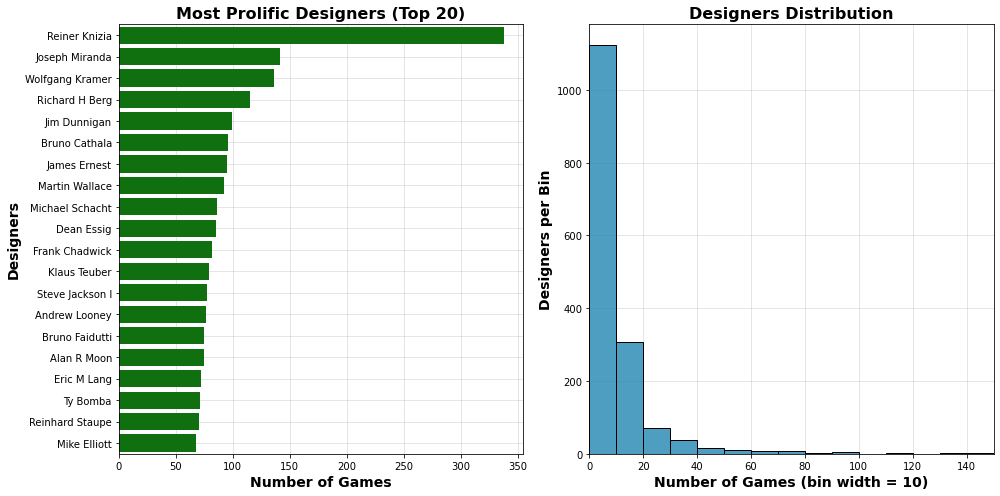

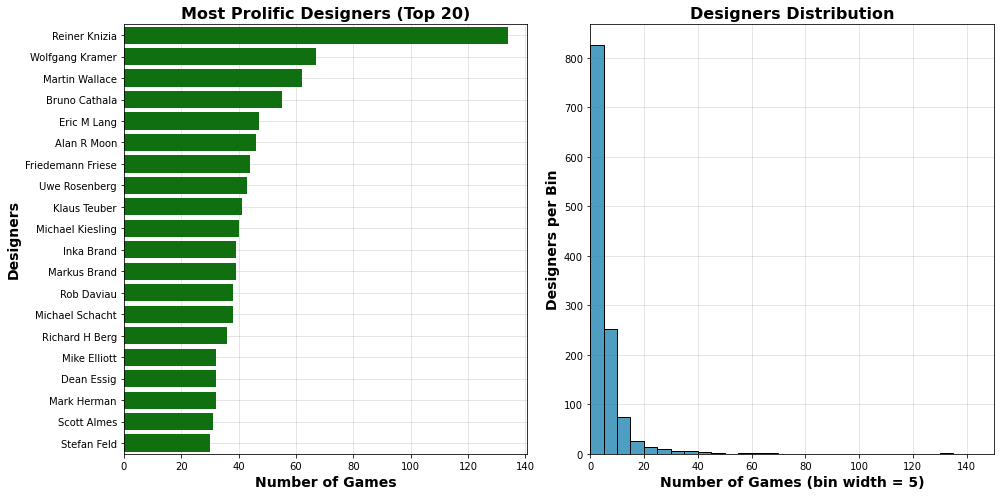

In [33]:
bad_rows = design_long[(design_long['Designer'] == 'LowExp Designer') | (design_long['Designer'] == 'Uncredited') ].index
# design_long.drop(bad_rows, inplace = True)

# Run Feature Distribution
feature_dist(design_long.drop(bad_rows), 'Designer', 20, 10)

design5k = pd.merge(design_long, bggid, how = 'right', on = 'BGGId')
bad_rows = design5k[(design5k['Designer'] == 'LowExp Designer') | (design5k['Designer'] == 'Uncredited') ].index

feature_dist(design5k.drop(bad_rows), 'Designer', 20, 5)

### Designer Top/Bottom Split (DF = design_topbot)

In [34]:
# Get rid of floating 'Jr.'
jr_index = design5k[design5k['Designer'] == 'Jr.'].index
design5k.drop(jr_index, inplace = True)

design_topbot = topbot_split(design_df, design5k, 'Designer', 'top_design', 'bot_design', 20)
design_topbot

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,BGGId,top_design,bot_design
0,174430,NaN,1.0
1,161936,NaN,1.0
2,167791,NaN,1.0
3,182028,NaN,1.0
4,12333,NaN,1.0
...,...,...,...
5926,322589,NaN,0.0
5927,305752,NaN,1.0
5928,315610,NaN,0.0
5929,280501,NaN,1.0


## Artist DF

In [37]:
# Load Designer Data
artist_df = pd.read_csv('data/game_info/artists_reduced.csv')
artist_df.columns = artist_df.columns.str.replace(r'[^\w\s]+', '')

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
# Run ohe_reverse function
artist_df['ohe'] = artist_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
artist_long = make_longer(artist_df, 'Artist')
avg_num_artist = pd.merge(artist_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Artist'].nunique().mean()

artist_long.head(10)

,BGGId,Artist
0,1,Harald Lieske
1,1,LowExp Artist
2,2,LowExp Artist
3,3,Franz Vohwinkel
4,4,LowExp Artist
5,5,Scott Okumura
6,5,Peter Whitley
7,6,LowExp Artist
8,7,Uncredited
9,7,LowExp Artist


### Artist Graph

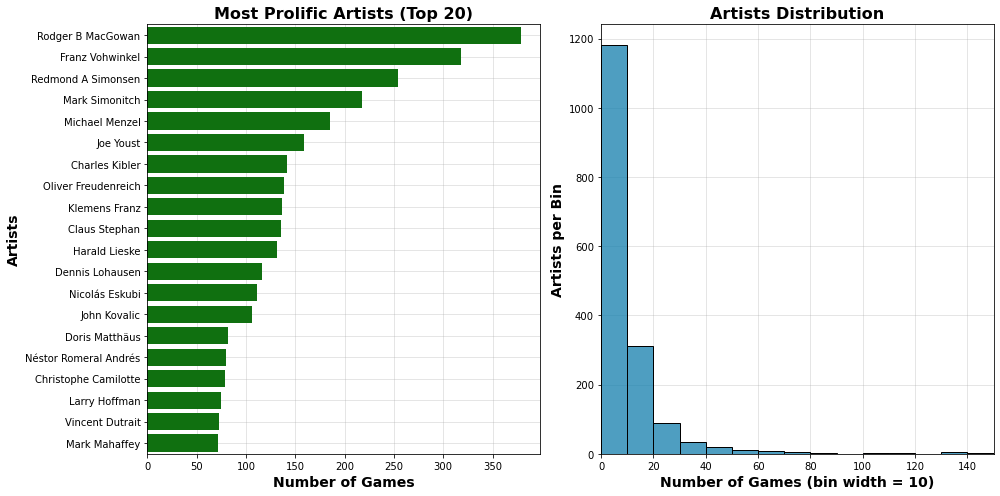

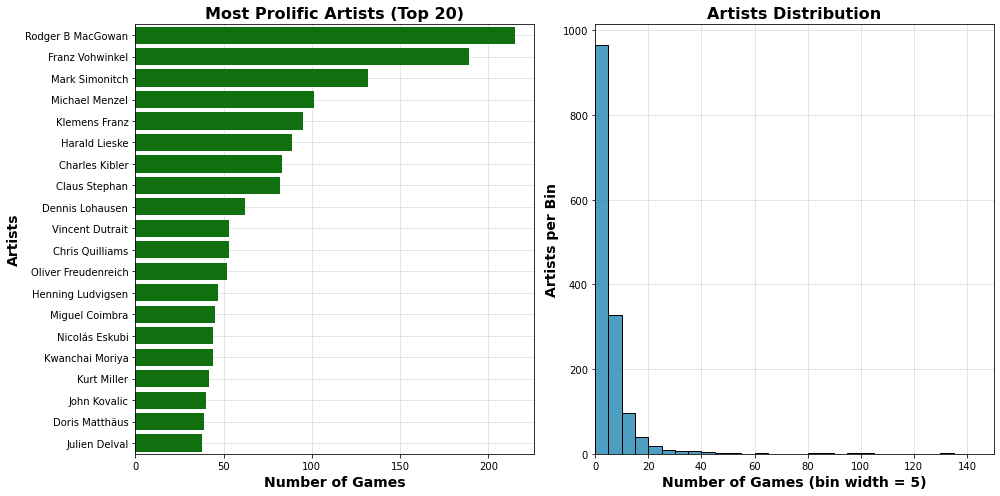

In [40]:
# Rows to remove before graphing...
bad_rows = artist_long[(artist_long['Artist'] == 'LowExp Artist') | (artist_long['Artist'] == 'Uncredited') ].index

# Run Feature Distribution
feature_dist(artist_long.drop(bad_rows), 'Artist', 20, 10)

artist5k = pd.merge(artist_long, bggid, how = 'right', on = 'BGGId')
bad_rows = artist5k[(artist5k['Artist'] == 'LowExp Artist') | (artist5k['Artist'] == 'Uncredited') ].index

feature_dist(artist5k.drop(bad_rows), 'Artist', 20, 5)

### Artist Top/Bottom Split (DF = artist_topbot)

In [41]:
# Split games by top and bottom artists
artist_topbot = topbot_split(artist_df, artist5k, 'Artist', 'top_artist', 'bot_artist', 20)
artist_topbot

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,BGGId,top_artist,bot_artist
0,174430,NaN,1.0
1,161936,NaN,1.0
2,167791,NaN,1.0
3,182028,NaN,1.0
4,12333,NaN,1.0
...,...,...,...
5926,322589,NaN,0.0
5927,305752,NaN,1.0
5928,315610,NaN,0.0
5929,280501,NaN,1.0


## Publisher DF

In [43]:
# Load in the Publisher Data
publish_df = pd.read_csv('data/game_info/publishers_reduced.csv')
                         
# Many column names include .LTD or other punctuation that makes this complicated.
# Use str.replace to remove unwanted punctuation
publish_df.columns = publish_df.columns.str.replace(r'[^\w\s]+', '')

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [44]:
# Run ohe_reverse function
publish_df['ohe'] = publish_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
publish_long = make_longer(publish_df, 'Publisher')
avg_num_publish = pd.merge(publish_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Publisher'].nunique().mean()

publish_long.head(10)

,BGGId,Publisher
0,1,Hans im Glück
1,1,Portal Games
2,1,Spielworxx
3,1,Stronghold Games
4,1,Valley Games Inc
5,1,YOKA Games
6,1,sternenschimmermeer
7,1,Moskito Spiele
8,2,ES Lowe
9,2,Milton Bradley


### Publisher Graph

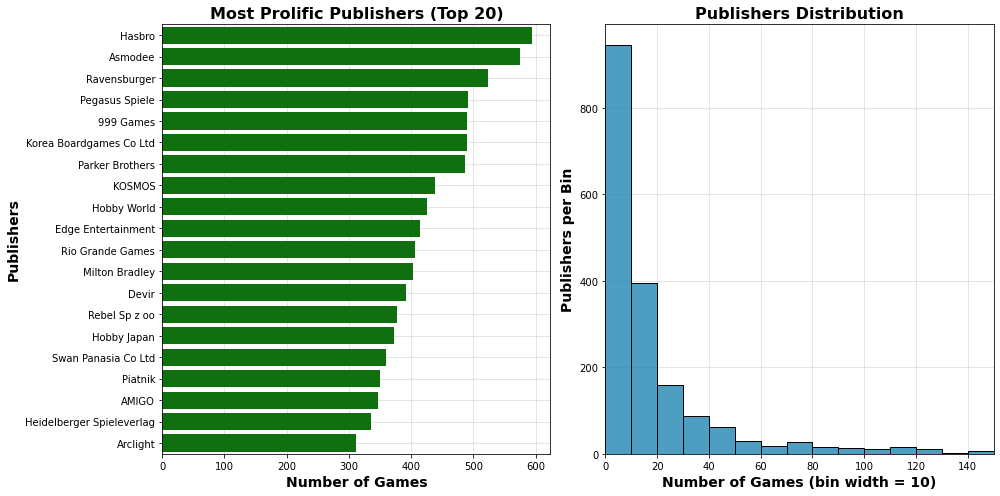

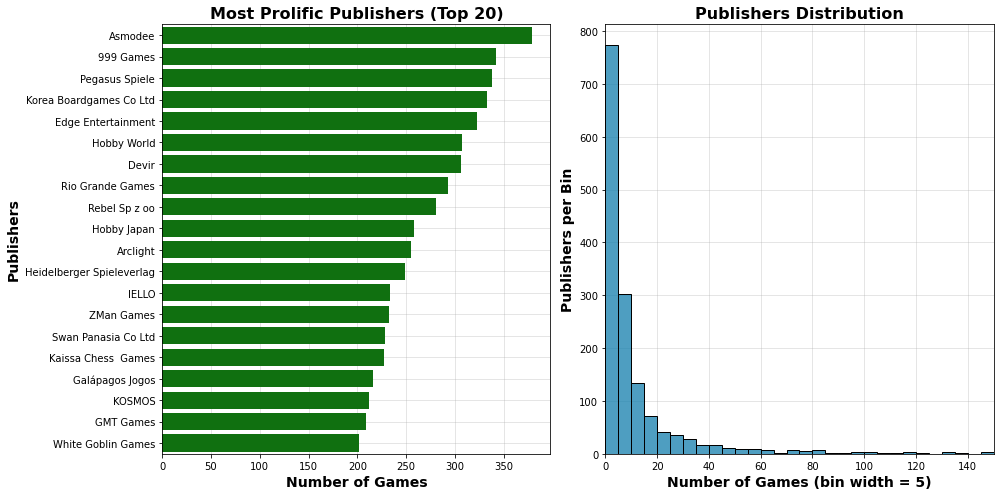

In [45]:
bad_rows = publish_long[(publish_long['Publisher'] == 'LowExp Publisher') |
                        (publish_long['Publisher'] == 'SelfPublished') |
                        (publish_long['Publisher'] == 'Web published')].index
# publish_long.drop(bad_rows, inplace = True)

# Run Feature Distribution
feature_dist(publish_long.drop(bad_rows), 'Publisher', 20, 10)

publish5k = pd.merge(publish_long, bggid, how = 'right', on = 'BGGId')
bad_rows = publish5k[(publish5k['Publisher'] == 'LowExp Publisher') |
                        (publish5k['Publisher'] == 'SelfPublished') |
                        (publish5k['Publisher'] == 'Web published')].index

feature_dist(publish5k.drop(bad_rows), 'Publisher', 20, 5)

### Publisher Top/Bottom Split (DF = publish_topbot)

In [46]:
# KeyError: "['Korea Boardgames Co.', 'Swan Panasia Co.'] not in index"
# list(publish_df.columns.sort_values())
# publish5k[publish5k['Publisher'] == 'Swan Panasia Co.']
publish_topbot = topbot_split(publish_df, publish5k, 'Publisher', 'top_publish', 'bot_publish', 20)
publish_topbot

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,BGGId,top_publish,bot_publish
0,174430,1.0,1.0
1,161936,1.0,1.0
2,167791,1.0,1.0
3,182028,1.0,1.0
4,12333,1.0,1.0
...,...,...,...
5926,322589,0.0,0.0
5927,305752,0.0,1.0
5928,315610,0.0,0.0
5929,280501,0.0,1.0


## Mechanics DF

In [49]:
# Load Mechanics Data
mech_df = pd.read_csv('data/game_info/mechanics.csv')

# Rename Columns that contain commas
mech_df = mech_df.rename(columns={'I Cut, You Choose':'I Cut You Choose', 'Deck, Bag, and Pool Building': 'Deck / Bag / Pool Building'})

In [50]:
# Run ohe_reverse function
mech_df['ohe'] = mech_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
mech_long = make_longer(mech_df, 'Mechanic')
avg_num_mech = pd.merge(mech_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Mechanic'].nunique().mean()

mech_long.head(10)

,BGGId,Mechanic
0,1,Alliances
1,1,Area Majority / Influence
2,1,Hand Management
3,1,Auction/Bidding
4,1,Simultaneous Action Selection
5,1,Dice Rolling
6,1,Negotiation
7,2,Trick-taking
8,3,Hand Management
9,3,Area Majority / Influence


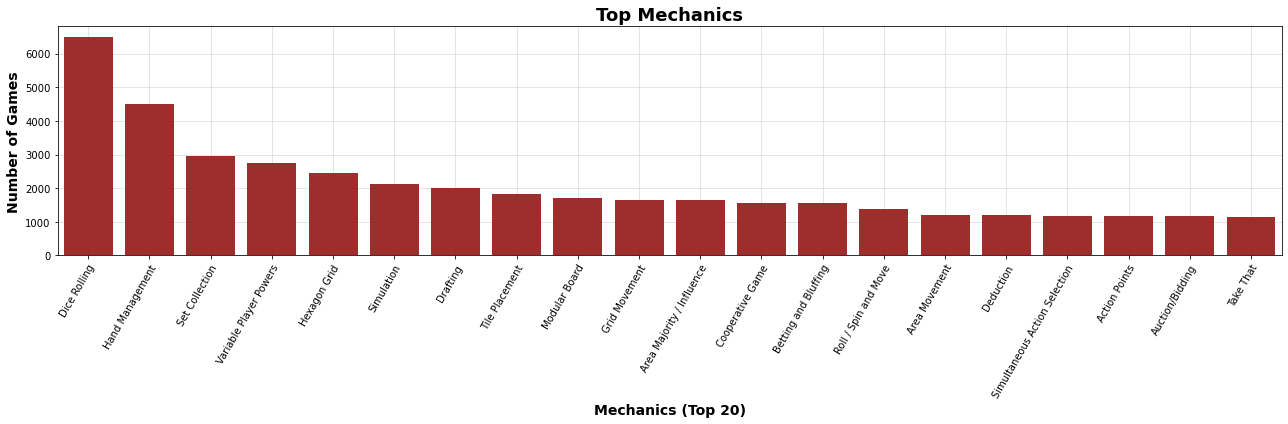

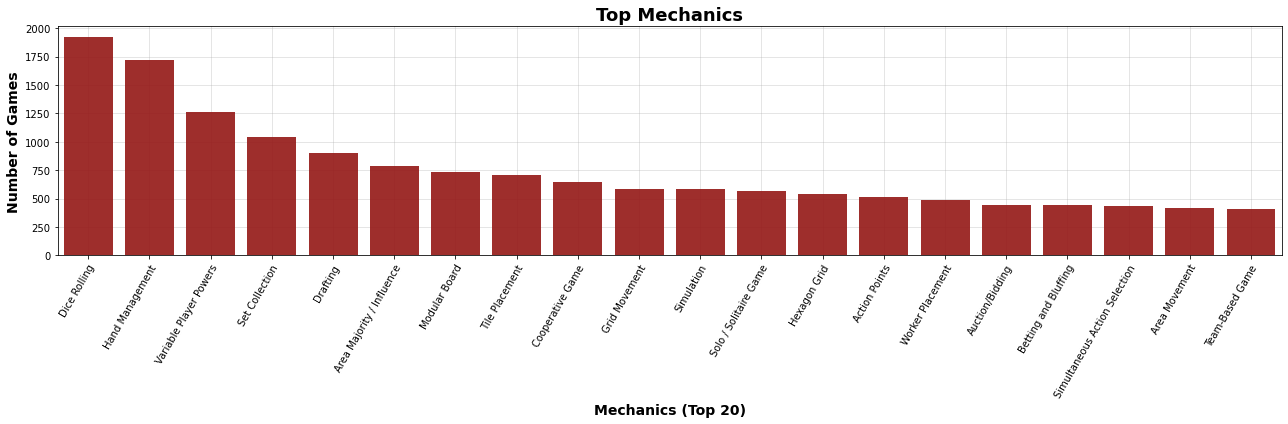

In [51]:
# Run Feature Distribution
feature_dist2(mech_long, 'Mechanic', 20)

mech5k = pd.merge(mech_long, bggid, how = 'right', on = 'BGGId')

feature_dist2(mech5k, 'Mechanic', 20)

## Sub-Categories DF

In [57]:
# Load in Subcategories
subcat_df = pd.read_csv('data/game_info/subcategories.csv')

In [58]:
# Run ohe_reverse function
subcat_df['ohe'] = subcat_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
subcat_long = make_longer(subcat_df, 'Subcat')
avg_num_subcat = pd.merge(subcat_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Subcat'].nunique().mean()

subcat_long.head(10)

,BGGId,Subcat
0,2,Card Game
1,5,Territory Building
2,9,Exploration
3,11,Card Game
4,17,Print & Play
5,17,Collectible Components
6,18,Miniatures
7,20,Miniatures
8,21,Exploration
9,22,Exploration


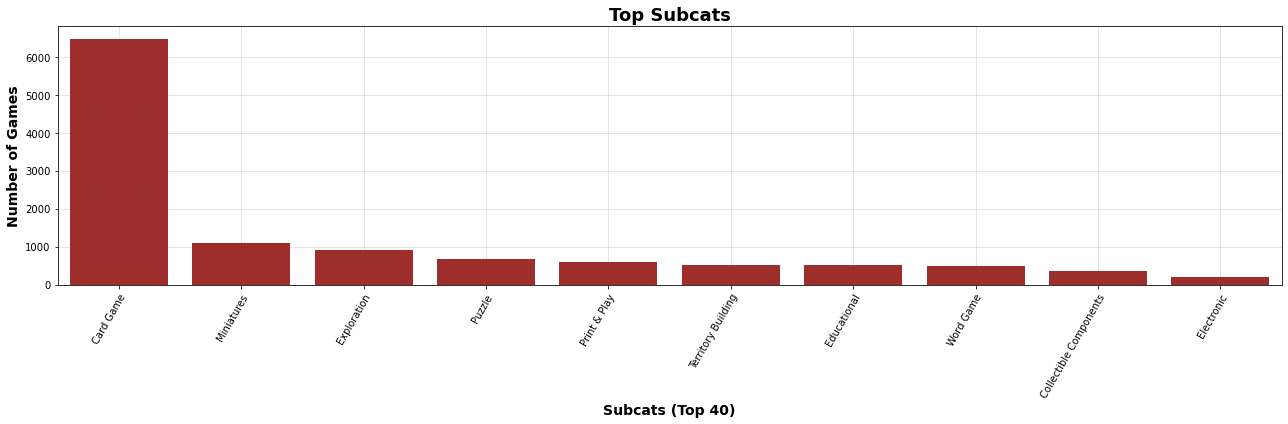

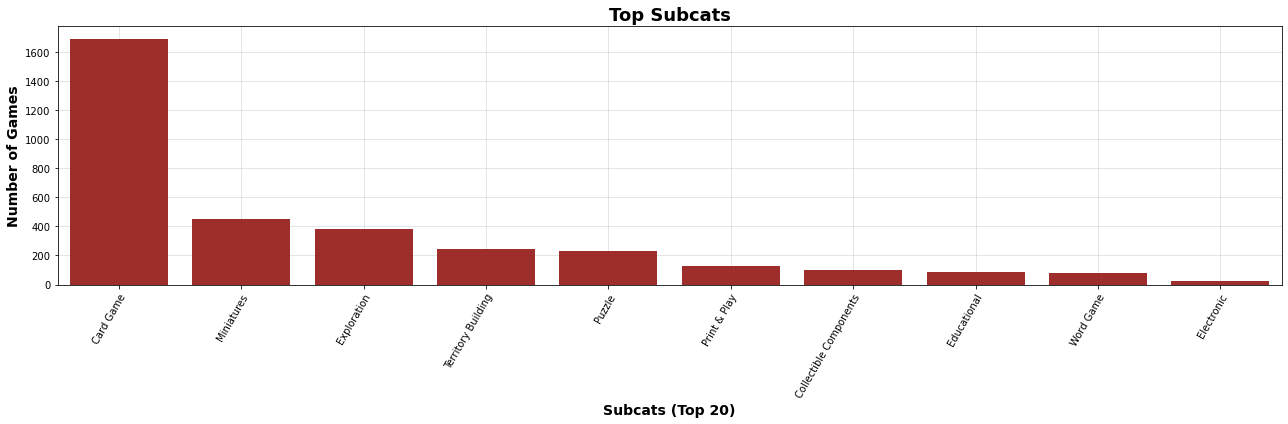

In [59]:
feature_dist2(subcat_long, 'Subcat', 40)

subcat5k = pd.merge(subcat_long, bggid, how = 'right', on = 'BGGId')

feature_dist2(subcat5k, 'Subcat', 20)

## Themes DF

In [60]:
theme_df = pd.read_csv('data/game_info/themes.csv')

theme_df.columns = theme_df.columns.str.replace(r'[^\w\s]+', '')

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
# Run ohe_reverse function
theme_df['ohe'] = theme_df.drop('BGGId', axis=1).apply(lambda row: ohe_reverse(row, list(row.index)), axis = 1) 

# Run make_longer
theme_long = make_longer(theme_df, 'Theme')
avg_num_theme = pd.merge(theme_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Theme'].nunique().mean()

theme_long.head(10)

,BGGId,Theme
0,1,Economic
1,1,Political
2,2,Fantasy
3,3,Medieval
4,3,Theme_Samurai
5,4,Ancient
6,5,Economic
7,6,Nautical
8,6,Civilization
9,8,Civilization


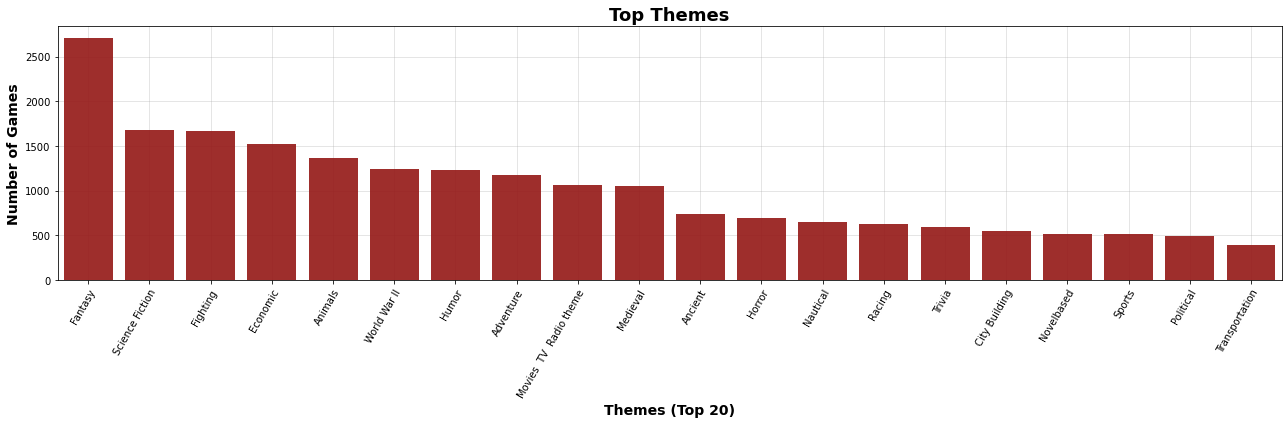

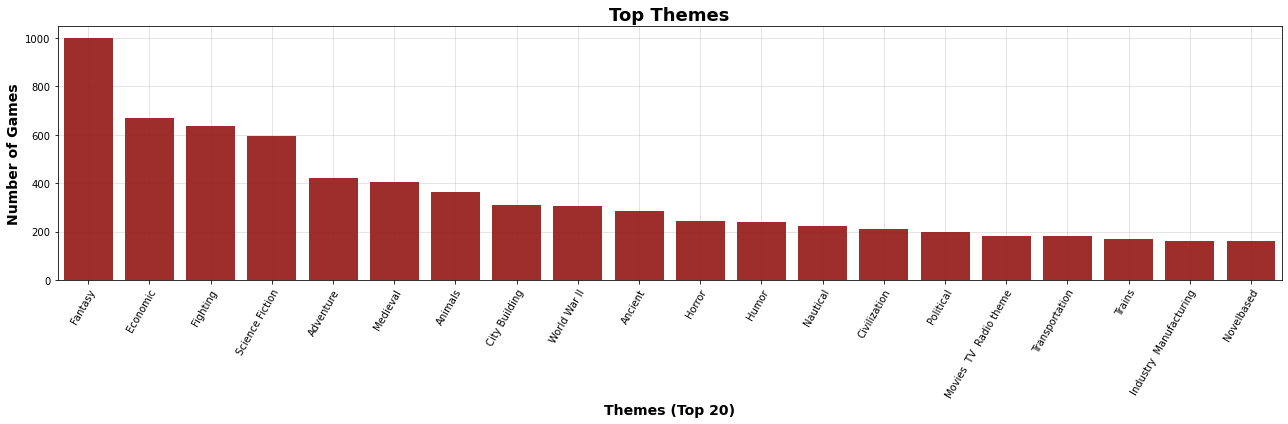

In [62]:
feature_dist2(theme_long, 'Theme', 20)

theme5k = pd.merge(theme_long, bggid, how = 'right', on = 'BGGId')

feature_dist2(theme5k, 'Theme', 20)

# Average Game Stats by Category

In [63]:
avg_num_design = pd.merge(design_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Designer'].nunique().mean()
avg_num_artist = pd.merge(artist_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Artist'].nunique().mean()
avg_num_publish = pd.merge(publish_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Publisher'].nunique().mean()
avg_num_mech = pd.merge(mech_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Mechanic'].nunique().mean()
avg_num_subcat = pd.merge(subcat_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Subcat'].nunique().mean()
avg_num_theme = pd.merge(theme_long, bggid, how = 'right', on = 'BGGId').groupby('BGGId')['Theme'].nunique().mean()

# avg_num_design = design5k.groupby('BGGId')['Designer'].nunique().mean()
# avg_num_artist = artist5k.groupby('BGGId')['Artist'].nunique().mean()
# avg_num_publish = publish5k.groupby('BGGId')['Publisher'].nunique().mean()
# avg_num_mech = mech5k.groupby('BGGId')['Mechanic'].nunique().mean()
# avg_num_subcat = subcat5k.groupby('BGGId')['Subcat'].nunique().mean()
# avg_num_theme = theme5k.groupby('BGGId')['Theme'].nunique().mean()

In [64]:
# Average Game Statistics
print(f'Average Game Statistics (Top 5000)')
print(f'   Number of Designers: {avg_num_design:.2f}')
print(f'   Number of Artists: {avg_num_artist:.2f}')
print(f'   Number of Publishers: {avg_num_publish:.2f}')
print(f'   Number of Mechanics: {avg_num_mech:.2f}')
print(f'   Number of Sub-Categories: {avg_num_subcat:.2f}')
print(f'   Number of Themes: {avg_num_theme:.2f}')

Average Game Statistics (Top 5000)
   Number of Designers: 1.35
   Number of Artists: 1.83
   Number of Publishers: 4.19
   Number of Mechanics: 4.19
   Number of Sub-Categories: 0.58
   Number of Themes: 1.83


## Games2 DF

In [66]:
games2 = pd.read_csv('data/game_info/games.csv')

In [67]:
games2.head()

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
0,1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.57979,3,5,...,21926,21926,0,1,0,0,0,0,0,0
1,2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.45440,3,4,...,21926,21926,0,1,0,0,0,0,0,0
2,3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.18227,2,4,...,21926,21926,0,1,0,0,0,0,0,0
3,4,Tal der Könige,triangular box luxurious large block tal der k...,1992,2.6667,6.60006,5.67954,1.23129,2,4,...,21926,21926,0,0,0,0,0,0,0,0
4,5,Acquire,acquire player strategically invest business t...,1964,2.5031,7.33861,7.14189,1.33583,2,6,...,21926,21926,0,1,0,0,0,0,0,0


In [68]:
games2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21925 entries, 0 to 21924
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BGGId                21925 non-null  int64  
 1   Name                 21925 non-null  object 
 2   Description          21924 non-null  object 
 3   YearPublished        21925 non-null  int64  
 4   GameWeight           21925 non-null  float64
 5   AvgRating            21925 non-null  float64
 6   BayesAvgRating       21925 non-null  float64
 7   StdDev               21925 non-null  float64
 8   MinPlayers           21925 non-null  int64  
 9   MaxPlayers           21925 non-null  int64  
 10  ComAgeRec            16395 non-null  float64
 11  LanguageEase         16034 non-null  float64
 12  BestPlayers          21925 non-null  int64  
 13  GoodPlayers          21925 non-null  object 
 14  NumOwned             21925 non-null  int64  
 15  NumWant              21925 non-null 

In [69]:
games2.drop(games2.iloc[:,30:40], inplace = True, axis = 1)
games2.drop(columns = ['Description', 'LanguageEase', 'StdDev', 'NumOwned',  'NumWant', 'NumWish', 'NumWeightVotes', 'NumComments'], inplace = True)
games2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21925 entries, 0 to 21924
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BGGId               21925 non-null  int64  
 1   Name                21925 non-null  object 
 2   YearPublished       21925 non-null  int64  
 3   GameWeight          21925 non-null  float64
 4   AvgRating           21925 non-null  float64
 5   BayesAvgRating      21925 non-null  float64
 6   MinPlayers          21925 non-null  int64  
 7   MaxPlayers          21925 non-null  int64  
 8   ComAgeRec           16395 non-null  float64
 9   BestPlayers         21925 non-null  int64  
 10  GoodPlayers         21925 non-null  object 
 11  MfgPlaytime         21925 non-null  int64  
 12  ComMinPlaytime      21925 non-null  int64  
 13  ComMaxPlaytime      21925 non-null  int64  
 14  MfgAgeRec           21925 non-null  int64  
 15  NumUserRatings      21925 non-null  int64  
 16  NumA

In [70]:
games2_test2 = games2[games2['NumUserRatings'] >= 100]

In [71]:
print('Number of 0 entries in each column')
for col in games2_test2.columns:
    num = games2_test2[games2_test2[col] == 0]['BGGId'].nunique()
    print(f'{col} has: {num}')

Number of 0 entries in each column
BGGId has: 0
Name has: 0
YearPublished has: 43
GameWeight has: 14
AvgRating has: 0
BayesAvgRating has: 0
MinPlayers has: 14
MaxPlayers has: 50
ComAgeRec has: 0
BestPlayers has: 10259
GoodPlayers has: 0
MfgPlaytime has: 47
ComMinPlaytime has: 29
ComMaxPlaytime has: 47
MfgAgeRec has: 394
NumUserRatings has: 0
NumAlternates has: 6011
NumExpansions has: 7881
NumImplementations has: 8765
IsReimplementation has: 10489
Family has: 0
Kickstarted has: 10080
Cat:Thematic has: 11079
Cat:Strategy has: 10016
Cat:War has: 10624
Cat:Family has: 10018
Cat:CGS has: 12020
Cat:Abstract has: 11613
Cat:Party has: 11618
Cat:Childrens has: 11731


In [72]:
games2_test = games2[(games2['NumUserRatings'] >= 100) & (games2['YearPublished'] != 0) & (games2['GameWeight'] != 0) 
& (games2['MinPlayers'] != 0) & (games2['MaxPlayers'] != 0) 
& (games2['ComMinPlaytime'] != 0) & (games2['ComMaxPlaytime'] != 0) 
& (games2['MfgAgeRec'] != 0) & (games2['MfgPlaytime'] != 0)]

In [73]:
games2_test['BGGId'].nunique()

11729

In [74]:
games2_test['BestPlayers'].value_counts()

0     9761
4      776
2      445
3      399
5      150
6       86
1       82
7       14
8       11
13       1
12       1
15       1
14       1
9        1
Name: BestPlayers, dtype: int64

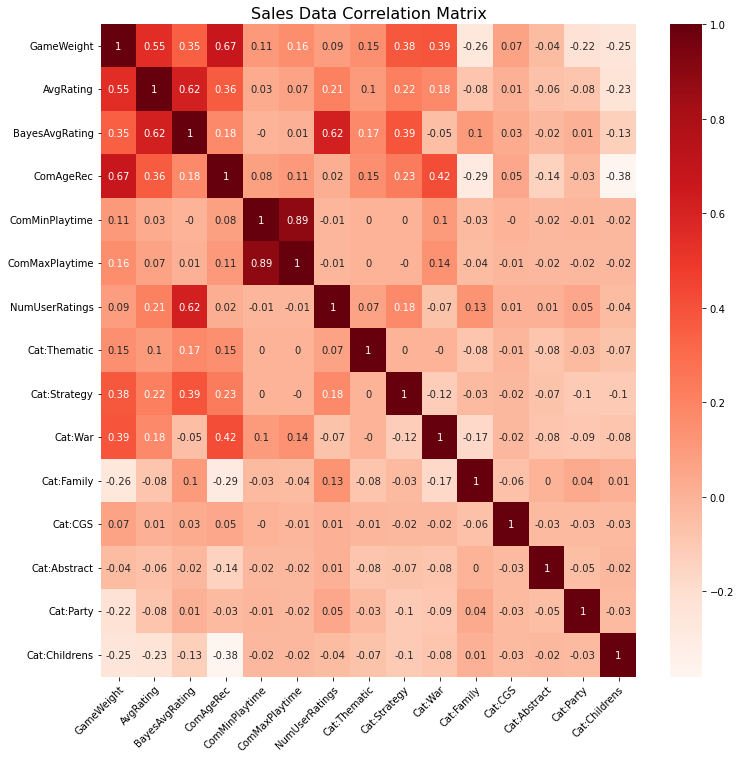

In [75]:
#Unfortunately it looks like 'BestPlayer' must be included in the drop list as the info in the DF does not match with the info on BGG. A number of the 0's are innacurate. 
corr_drop = ['YearPublished', 'BGGId', 'NumAlternates', 'NumExpansions', 'NumImplementations', 'IsReimplementation', 'Kickstarted', 'MfgPlaytime', 'MfgAgeRec', 'MinPlayers', 'MaxPlayers', 'BestPlayers']
corr = round(games2_test.drop(columns = corr_drop).corr(), 2)
# corr = round(games2.drop(columns = corr_drop).corr(), 2)
# corr = round(corr.corr(), 2)

fig, ax = plt.subplots(figsize= (12,12))
sns.heatmap(corr, cmap = 'Reds', annot = True, ax = ax)
plt.title('Sales Data Correlation Matrix', fontsize = 16)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor');

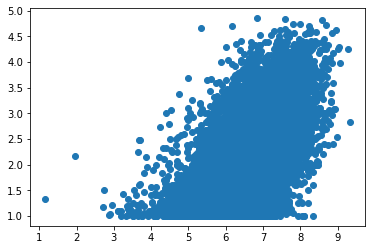

In [76]:
plt.scatter(games2_test['AvgRating'], games2_test['GameWeight']);

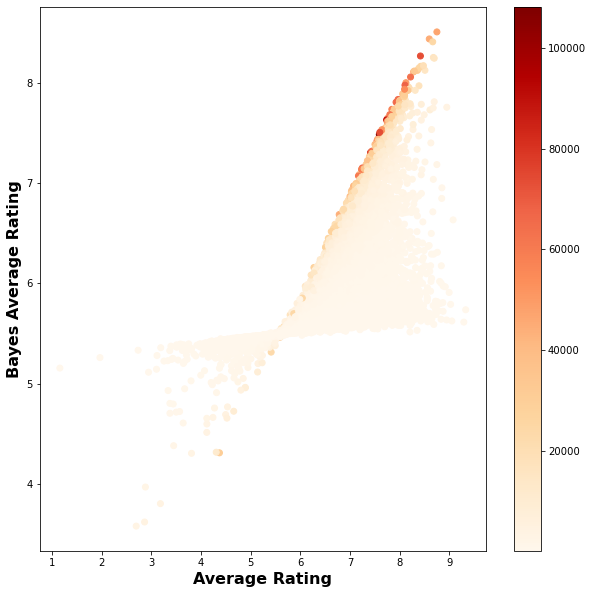

In [77]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(games2_test['AvgRating'], games2_test['BayesAvgRating'], cmap = 'OrRd', c = games2_test['NumUserRatings'], alpha = 1);
plt.colorbar();
plt.xlabel('Average Rating', fontsize = 16, weight = 'semibold')
plt.ylabel('Bayes Average Rating', fontsize = 16, weight = 'semibold');

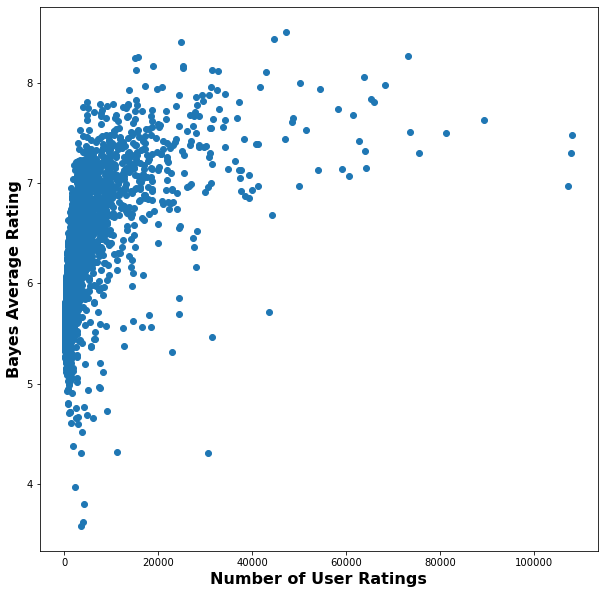

In [78]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(games2_test['NumUserRatings'], games2_test['BayesAvgRating']);
plt.xlabel('Number of User Ratings', fontsize = 16, weight = 'semibold')
plt.ylabel('Bayes Average Rating', fontsize = 16, weight = 'semibold');

# Merge Main

In [79]:
# Merge the rank and the initial game DF..
main_df = pd.merge(game_df, rank_df, how = 'right', on = 'BGGId')

# Lose rows that are duplicated in the other DF..
main_df.drop(main_df.columns[2:20], axis = 1, inplace = True)

In [80]:
df_list = [mech_df, subcat_df, theme_df]#, design_topbot, artist_topbot, publish_topbot]# , design_df, artist_df, publish_df]

main2_df = games2
for df in df_list:
    main2_df = pd.merge(main2_df, df, how = 'left', on = 'BGGId')
    # main2_df = main2_df.drop(columns = ['ohe'])

main2_df.drop(columns = 'Name', inplace = True)
main2_df.fillna(value = 0, inplace = True)

In [81]:
merge_main = pd.merge(main_df, main2_df, how = 'inner', on = "BGGId")
merge_main.reset_index(inplace = True, drop = True)
merge_main

,BGGId,name,2019-09-07,2019-09-14,2019-09-21,2019-09-28,2019-10-05,2019-10-12,2019-10-19,2019-10-26,...,Theme_Fashion,Theme_Geocaching,Theme_Ecology,Theme_Chernobyl,Theme_Photography,Theme_French Foreign Legion,Theme_Cruise ships,Theme_Apache Tribes,Theme_Rivers,Theme_Flags identification
0,174430,Gloomhaven,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,161936,Pandemic Legacy: Season 1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,167791,Terraforming Mars,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,182028,Through the Ages: A New Story of Civilization,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12333,Twilight Struggle,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,343526,G.I. JOE Deck-Building Game,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5905,260147,Europe Divided,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5906,305752,Gate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5907,280501,Three-Dragon Ante: Legendary Edition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Machine Learning - Linear Regression
Attempt to model avgrank

## Preprocessing

Identify Features

In [82]:
# Bring in a copy to work with
merge_ml = merge_main.copy()

In [83]:
## Feature Selection and 
# Drop date columns
merge_ml.drop(merge_ml.columns[2:133], axis = 1, inplace = True)

# Drop unique columns (ID, name)
merge_ml.drop(columns = ['BGGId', 'name'], inplace = True) 
                         
# Drop columns used for EDA that might have spill over (avg_rank, num_times, topx)
merge_ml.drop(columns = ['num_times', 'avg_rank', 'Top_100', 'Top_20'], inplace = True)

# While interesting best and good players have ~4000 entries with 0's so this feature will not be particularly useful for our analysis.
merge_ml.drop(columns = ['BestPlayers', 'GoodPlayers', 'Family'], inplace = True)

merge_ml.drop(columns = ['NumUserRatings', 'NumAlternates', 'NumExpansions', 'NumImplementations', 'IsReimplementation'], inplace=True)

# Drop Community Stats as we want to know what the Manucaturer can do to increase sales/ranking. 
merge_ml.drop(columns = ['ComAgeRec', 'ComMinPlaytime', 'ComMaxPlaytime'], inplace=True) # Community
# merge_ml.drop(columns = ['MfgAgeRec', 'MfgPlaytime'], inplace=True) # Manufacturer

# Data came preloaded with a number of designers/publishers/artists grouped as low experience
# Unfortunately grouping these as such gives them significantly more weight than intended
# Will caputure these with our top/bot split.
# merge_ml.drop(columns = ['LowExp Designer', 'LowExp Publisher', 'LowExp Artist'], inplace=True)

In [84]:
print(f'Theme Long Length {len(theme_long.index)}')
theme_long['Theme'].value_counts().tail(139).sum()
bad_themes = list(theme_long['Theme'].value_counts().tail(139).index)

Theme Long Length 32379


In [85]:
print(f'Mech Long Length {len(mech_long.index)}')
mech_long['Mechanic'].value_counts().tail(70).sum()
bad_mech = list(mech_long['Mechanic'].value_counts().tail(70).index)

Mech Long Length 68080


In [86]:
na_list = ['YearPublished', 'GameWeight', 'MinPlayers', 'MaxPlayers', 'MfgPlaytime', 'MfgAgeRec']

merge_ml[na_list] = merge_ml[na_list].replace({0: np.nan})

merge_ml.drop(columns = bad_themes, inplace = True)
merge_ml.drop(columns = bad_mech, inplace = True)

## Instantiate Transformers

In [87]:
# Transformers
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = StandardScaler()

num_sel = make_column_selector(dtype_include = 'number')

# Preprocessor
processor = make_pipeline(imputer, StandardScaler())

## Set Target and Feature Matrix

In [88]:
X = merge_ml.drop(columns = ['AvgRating', 'BayesAvgRating'])
y = merge_ml['AvgRating']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 47)

### Dummy Model

In [95]:
%%time 
## Dummy Model for comparison
dummy_pipe = make_pipeline(processor, DummyRegressor(strategy = 'mean'))
dummy_pipe.fit(X_train, y_train)

metrics = model_eval(dummy_pipe, 'Dummy Model', X_train, X_test, y_train, y_test)
regressperformance  = regressperformance.append(metrics, ignore_index = True)

,model,Type,R2,MAE,MSE,RMSE
0,Dummy Model,Training,0.000,0.459,0.317,0.563
1,Dummy Model,Testing,-0.001,0.470,0.336,0.580


Wall time: 71.9 ms


### Linear Regression

In [94]:
%%time
reg = LinearRegression()
reg_pipe = make_pipeline(processor, reg)
reg_pipe.fit(X_train, y_train)

metrics = model_eval(reg_pipe, 'Linear Regression', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

,model,Type,R2,MAE,MSE,RMSE
0,Linear Regression,Training,0.475,0.324,0.167,0.408
1,Linear Regression,Testing,0.421,0.346,0.195,0.441


Wall time: 106 ms


### Simple Decision Tree

In [96]:
%%time 
dec_tree = make_pipeline(processor, DecisionTreeRegressor(random_state = 42))
dec_tree.fit(X_train, y_train)

metrics = model_eval(dec_tree, 'Decision Tree', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

,model,Type,R2,MAE,MSE,RMSE
0,Decision Tree,Training,1.000,0.000,0.000,0.000
1,Decision Tree,Testing,0.157,0.417,0.283,0.532


Wall time: 162 ms


### Bagged Forest

In [97]:
%%time 
bagreg = make_pipeline(processor, BaggingRegressor(random_state=42))
bagreg.fit(X_train, y_train)

metrics = model_eval(bagreg, 'Bagged Forest', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

,model,Type,R2,MAE,MSE,RMSE
0,Bagged Forest,Training,0.918,0.119,0.026,0.162
1,Bagged Forest,Testing,0.531,0.311,0.157,0.397


Wall time: 720 ms


### Random Forest Regression

In [98]:
%%time 
rf_pipe = make_pipeline(processor, RandomForestRegressor(random_state = 42))
rf_pipe.fit(X_train, y_train)

metrics = model_eval(rf_pipe, 'Random Forest', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

,model,Type,R2,MAE,MSE,RMSE
0,Random Forest,Training,0.941,0.107,0.019,0.137
1,Random Forest,Testing,0.568,0.300,0.145,0.381


Wall time: 5.88 s


### Gradient Boost Regression

In [99]:
%%time
grad_pipe = make_pipeline(processor, GradientBoostingRegressor(random_state = 42))
grad_pipe.fit(X_train, y_train)

metrics = model_eval(grad_pipe, 'Gradient Boosting', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

,model,Type,R2,MAE,MSE,RMSE
0,Gradient Boosting,Training,0.635,0.271,0.116,0.340
1,Gradient Boosting,Testing,0.562,0.305,0.147,0.384


Wall time: 1.56 s


### XGBoost

In [100]:
%%time
xgb_pipe = make_pipeline(processor, XGBRegressor(random_state = 42))
xgb_pipe.fit(X_train, y_train)

metrics = model_eval(xgb_pipe, 'XGB Regressor', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

,model,Type,R2,MAE,MSE,RMSE
0,XGB Regressor,Training,0.878,0.148,0.039,0.197
1,XGB Regressor,Testing,0.567,0.299,0.145,0.381


Wall time: 1.13 s


### LGBM Regressor

In [101]:
%%time
lgbm_pipe = make_pipeline(processor, LGBMRegressor(random_state = 42))
lgbm_pipe.fit(X_train, y_train)

metrics = model_eval(lgbm_pipe, 'LGBM Regressor', X_train, X_test, y_train, y_test)
regressperformance = regressperformance.append(metrics, ignore_index = True)

,model,Type,R2,MAE,MSE,RMSE
0,LGBM Regressor,Training,0.769,0.215,0.073,0.271
1,LGBM Regressor,Testing,0.607,0.287,0.132,0.363


Wall time: 351 ms


## Model Performance Overview - Regression

In [102]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

regressperformance

,model name,R-Squared (R2),Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE)
0,Dummy Model,-0.001,0.470,0.336,0.580
1,Linear Regression,0.421,0.346,0.195,0.441
2,Linear Regression,0.421,0.346,0.195,0.441
3,Linear Regression,0.421,0.346,0.195,0.441
4,Dummy Model,-0.001,0.470,0.336,0.580
5,Decision Tree,0.157,0.417,0.283,0.532
6,Bagged Forest,0.531,0.311,0.157,0.397
7,Random Forest,0.568,0.300,0.145,0.381
8,Gradient Boosting,0.562,0.305,0.147,0.384
9,XGB Regressor,0.567,0.299,0.145,0.381


By all metrics the Light Boosting Regression Model outperforms the competition. We will attempt to hyperparameter tune that model to see if we can get further performance improvement. 

## Feature Importance

In [103]:
feature_names = num_sel(X_train)
coefs = lgbm_pipe.named_steps['lgbmregressor'].feature_importances_

lgbm_importance = pd.Series(coefs, index = feature_names)
# (importance.sort_values(ascending = False)/10).head(30)
(lgbm_importance.sort_values(ascending = False)/30)

GameWeight                   15.100
YearPublished                13.267
MfgPlaytime                   5.833
MaxPlayers                    5.767
MfgAgeRec                     4.633
                              ...  
Measurement Movement          0.000
Hidden Movement               0.000
Comic Book  Strip             0.000
Mature  Adult                 0.000
American Revolutionary War    0.000
Length: 190, dtype: float64

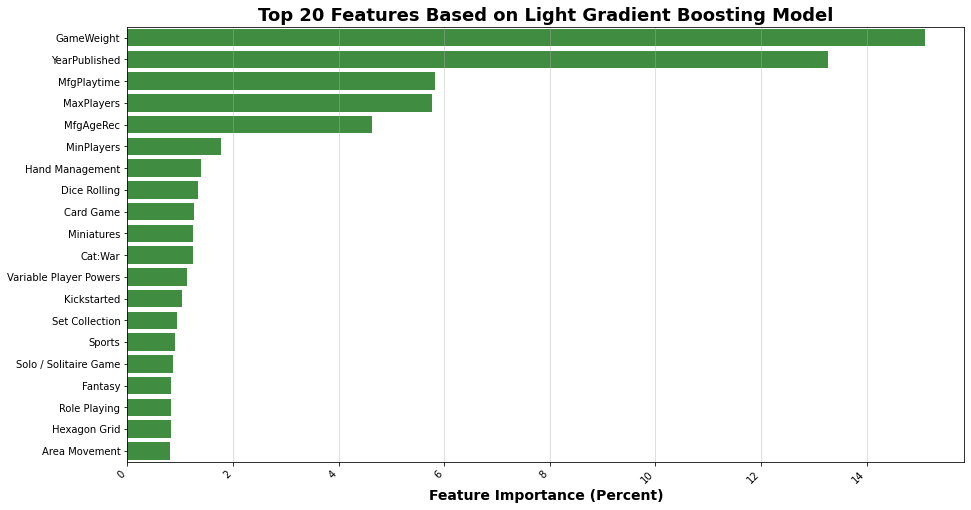

In [104]:
importance10 = (lgbm_importance.sort_values(ascending = False)/30).head(20)
plt.figure(figsize = (15, 8))
sns.barplot(y = importance10.index, x = importance10.values, color = 'green', alpha = .8)
plt.xticks(rotation = 45, ha = 'right')
plt.grid(axis = 'x', alpha = .5)
plt.title('Top 20 Features Based on Light Gradient Boosting Model', fontsize = 18, weight = 'bold')
plt.xlabel('Feature Importance (Percent)', fontsize=14, weight = 'semibold')
plt.ylabel('', fontsize=16);

## HyperTune

In [105]:
lgbm_pipe.get_params()

{'memory': None,
 'steps': [('pipeline',
   Pipeline(steps=[('simpleimputer', SimpleImputer()),
                   ('standardscaler', StandardScaler())])),
  ('lgbmregressor', LGBMRegressor(random_state=42))],
 'verbose': False,
 'pipeline': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 'lgbmregressor': LGBMRegressor(random_state=42),
 'pipeline__memory': None,
 'pipeline__steps': [('simpleimputer', SimpleImputer()),
  ('standardscaler', StandardScaler())],
 'pipeline__verbose': False,
 'pipeline__simpleimputer': SimpleImputer(),
 'pipeline__standardscaler': StandardScaler(),
 'pipeline__simpleimputer__add_indicator': False,
 'pipeline__simpleimputer__copy': True,
 'pipeline__simpleimputer__fill_value': None,
 'pipeline__simpleimputer__missing_values': nan,
 'pipeline__simpleimputer__strategy': 'mean',
 'pipeline__simpleimputer__verbose': 0,
 'pipeline__standardscaler__copy': True,
 'pipeline__standardscaler__with_mean': T

In [106]:
params = {'lgbmregressor__n_estimators': range(100,1101, 200),
          'lgbmregressor__learning_rate': [.01, .1, .2],
          'lgbmregressor__num_leaves': range(100,2101, 200),
          'lgbmregressor__max_depth': range(3,10)}

In [107]:
%%time 
# lgbm_grid = RandomizedSearchCV(lgbm_pipe, params)

# lgbm_grid.fit(X_train, y_train)

Wall time: 0 ns


In [108]:
# lgbm_grid.best_params_

#best estimators
# {'lgbmregressor__learning_rate': 0.1,
#  'lgbmregressor__max_depth': 3,
#  'lgbmregressor__n_estimators': 500,
#  'lgbmregressor__num_leaves': 1100}

In [109]:
best_lgbm = LGBMRegressor(learning_rate = 0.1,
                          max_depth = 5,
                          n_estimators = 500,
                          num_leaves = 700)
lgbm_pipe = make_pipeline(processor, best_lgbm)
lgbm_pipe.fit(X_train, y_train)

metrics = model_eval(lgbm_pipe, 'Best LGBM Regressor', X_train, X_test, y_train, y_test)

,model,Type,R2,MAE,MSE,RMSE
0,Best LGBM Regressor,Training,0.806,0.195,0.062,0.248
1,Best LGBM Regressor,Testing,0.601,0.288,0.134,0.366


In [110]:
best_coefs = lgbm_pipe.named_steps['lgbmregressor'].feature_importances_

importance = pd.Series(best_coefs, index = feature_names)
(importance.sort_values(ascending = False)/30).head(30)

GameWeight                   34.500
YearPublished                26.267
MfgPlaytime                  14.533
MfgAgeRec                    11.100
MaxPlayers                   10.100
MinPlayers                    3.700
Dice Rolling                  3.167
Hand Management               2.733
Card Game                     2.633
Kickstarted                   2.233
Variable Player Powers        2.033
Set Collection                1.900
Cat:War                       1.900
Cat:Strategy                  1.833
Cat:Family                    1.567
Simulation                    1.567
Fantasy                       1.400
Drafting                      1.400
Hexagon Grid                  1.233
Sports                        1.200
Economic                      1.100
Area Movement                 1.100
Point to Point Movement       1.067
Fighting                      1.067
Deck / Bag / Pool Building    1.067
Miniatures                    1.067
Action Points                 1.000
Science Fiction             

# Machine Learning - Classification

## Preprocessing

In [111]:
# Bring in a copy to work with
merge_ml2 = merge_main.copy()

In [112]:
## Feature Selection and 
# Drop date columns
merge_ml2.drop(merge_ml2.columns[2:133], axis = 1, inplace = True)

# Apply the same drops as before.
merge_ml2.drop(columns = ['BGGId', 'name', 'num_times', 'avg_rank', 'Top_20', 
                          'BestPlayers', 'GoodPlayers', 'Family', 'NumUserRatings', 
                          'NumAlternates', 'NumExpansions', 'NumImplementations',
                          'IsReimplementation', 'ComAgeRec', 'ComMinPlaytime', 
                          'ComMaxPlaytime'], inplace = True) #, 'LowExp Designer', 'LowExp Publisher', 'LowExp Artist'], inplace = True) 
                        

In [113]:
na_list = ['YearPublished', 'GameWeight', 'MinPlayers', 'MaxPlayers', 'MfgPlaytime', 'MfgAgeRec']

merge_ml2[na_list] = merge_ml[na_list].replace({0: np.nan})

merge_ml2.drop(columns = bad_themes, inplace = True)
merge_ml2.drop(columns = bad_mech, inplace = True)

In [114]:
X = merge_ml2.drop(columns = ['AvgRating', 'BayesAvgRating', 'Top_100'])
y = merge_ml2['Top_100']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 47)

### KNN Model

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1445
        True       0.50      0.03      0.06        33

    accuracy                           0.98      1478
   macro avg       0.74      0.51      0.52      1478
weighted avg       0.97      0.98      0.97      1478



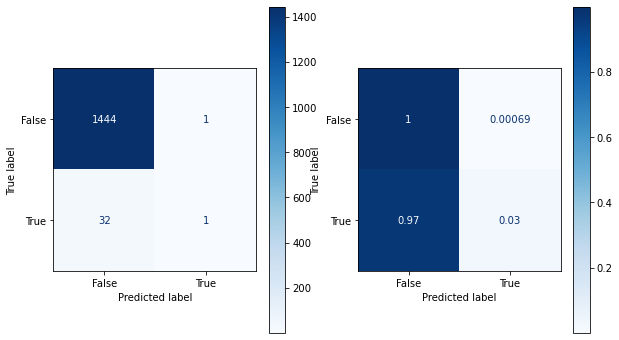

In [115]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(processor, knn)
knn_pipe.fit(X_train, y_train)

metrics = class_eval(knn_pipe, 'K Nearest Neighbor', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Logistic Regression

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1445
        True       0.17      0.18      0.18        33

    accuracy                           0.96      1478
   macro avg       0.58      0.58      0.58      1478
weighted avg       0.96      0.96      0.96      1478



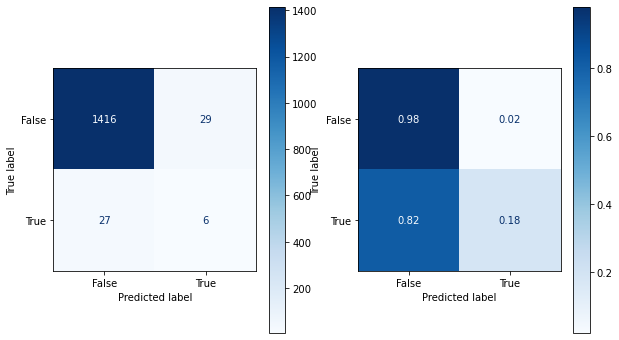

In [116]:
logreg_pipe = make_pipeline(processor, LogisticRegression())
logreg_pipe.fit(X_train, y_train)

metrics = class_eval(logreg_pipe, 'Log Reg', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Logistic Regression Balanced

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

       False       0.99      0.94      0.96      1445
        True       0.18      0.58      0.27        33

    accuracy                           0.93      1478
   macro avg       0.58      0.76      0.62      1478
weighted avg       0.97      0.93      0.95      1478



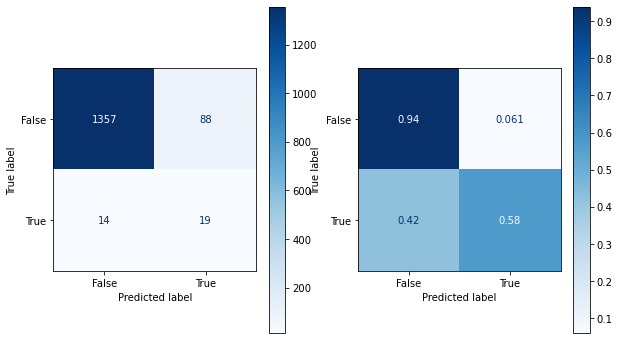

In [117]:
logreg_balanced = make_pipeline(processor, LogisticRegression(class_weight='balanced'))
logreg_balanced.fit(X_train, y_train)

metrics = class_eval(logreg_balanced, 'Log Reg Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Decision Tree Classifier

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1445
        True       0.21      0.18      0.20        33

    accuracy                           0.97      1478
   macro avg       0.60      0.58      0.59      1478
weighted avg       0.96      0.97      0.97      1478



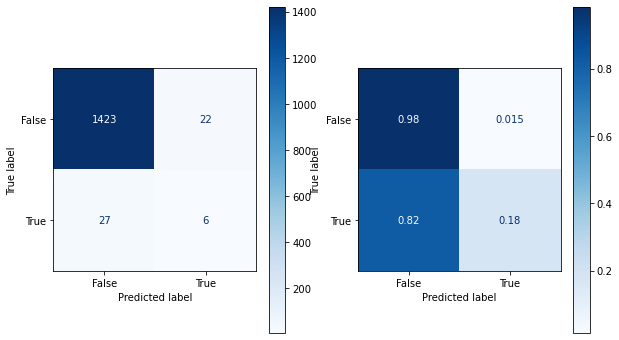

In [118]:
dec_tree_pipe = make_pipeline(processor, DecisionTreeClassifier(random_state = 42))
dec_tree_pipe.fit(X_train, y_train)

metrics = class_eval(dec_tree_pipe, 'Decision Tree', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Decision Tree Balanced

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1445
        True       0.13      0.12      0.12        33

    accuracy                           0.96      1478
   macro avg       0.55      0.55      0.55      1478
weighted avg       0.96      0.96      0.96      1478



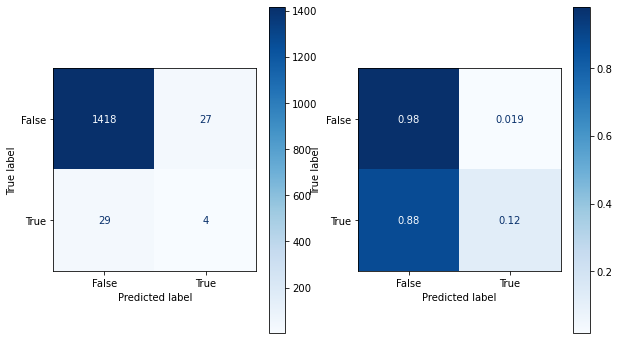

In [119]:
dec_tree_balance = make_pipeline(processor, 
                              DecisionTreeClassifier(random_state = 42, class_weight = 'balanced'))
dec_tree_balance.fit(X_train, y_train)

metrics = class_eval(dec_tree_balance, 'Decision Tree Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Bagged Trees

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1445
        True       0.50      0.12      0.20        33

    accuracy                           0.98      1478
   macro avg       0.74      0.56      0.59      1478
weighted avg       0.97      0.98      0.97      1478



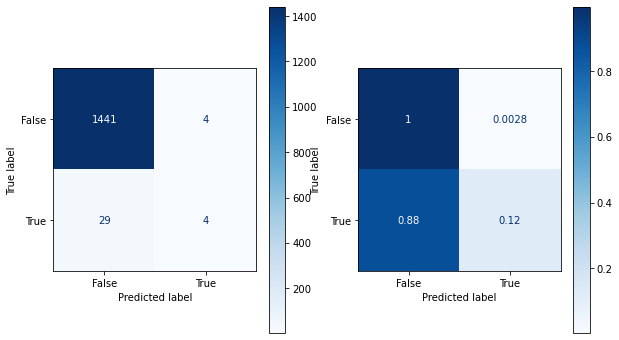

In [120]:
bag_pipe = make_pipeline(processor, BaggingClassifier(random_state = 42))
bag_pipe.fit(X_train, y_train)

metrics = class_eval(bag_pipe, 'Bagged Trees Class', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Random Forest Classifier

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1445
        True       0.50      0.06      0.11        33

    accuracy                           0.98      1478
   macro avg       0.74      0.53      0.55      1478
weighted avg       0.97      0.98      0.97      1478



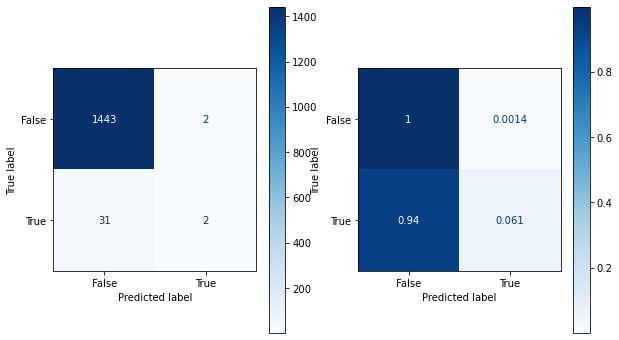

In [121]:
rf_pipe = make_pipeline(processor, RandomForestClassifier(random_state = 42))
rf_pipe.fit(X_train, y_train)

metrics = class_eval(rf_pipe, 'Random Forest', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Random Forest Balanced

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1445
        True       1.00      0.06      0.11        33

    accuracy                           0.98      1478
   macro avg       0.99      0.53      0.55      1478
weighted avg       0.98      0.98      0.97      1478



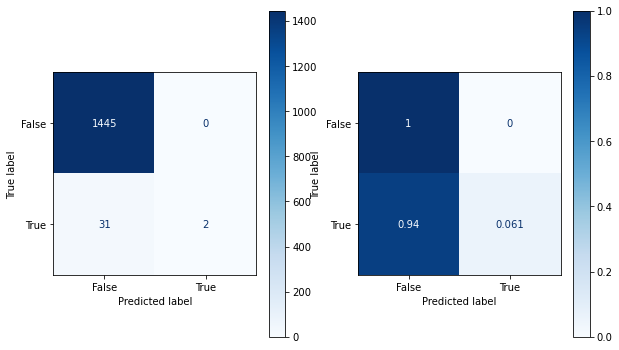

In [122]:
rf_balanced = make_pipeline(processor, 
                        RandomForestClassifier(random_state = 42, class_weight = 'balanced'))
rf_balanced.fit(X_train, y_train)

metrics = class_eval(rf_balanced, 'Random Forest Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### Gradient Boost Classifier

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1445
        True       0.54      0.21      0.30        33

    accuracy                           0.98      1478
   macro avg       0.76      0.60      0.65      1478
weighted avg       0.97      0.98      0.97      1478



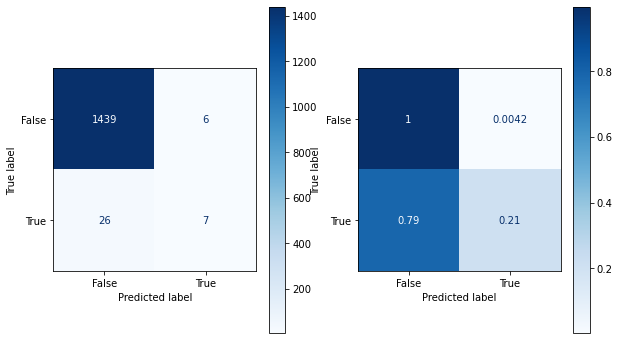

In [123]:
gbc_pipe = make_pipeline(processor, GradientBoostingClassifier())
gbc_pipe.fit(X_train, y_train)

metrics = class_eval(gbc_pipe, 'Gradient Boost Class', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### XGBoost Classifier

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1445
        True       0.64      0.21      0.32        33

    accuracy                           0.98      1478
   macro avg       0.81      0.60      0.65      1478
weighted avg       0.97      0.98      0.97      1478



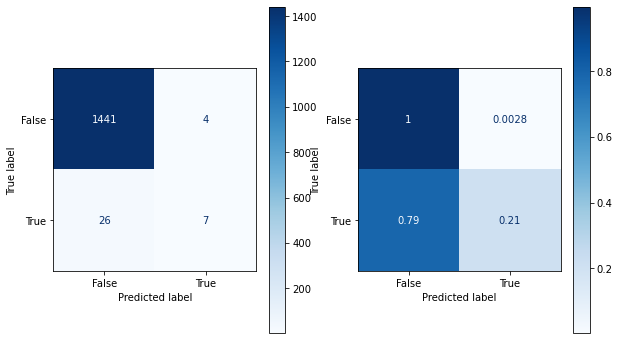

In [124]:
xgb_pipe = make_pipeline(processor, XGBClassifier())
xgb_pipe.fit(X_train, y_train)

metrics = class_eval(xgb_pipe, 'XGBoost Class', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

XGBoost Balanced

[13:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1445
        True       0.64      0.21      0.32        33

    accuracy                           0.98      1478
   macro avg       0.81      0.60      0.65      1478
weighted avg       0.97      0.98      0.97      1478



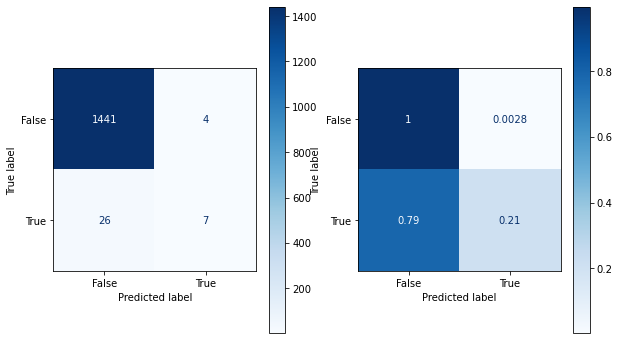

In [125]:
xgb_balanced = make_pipeline(processor, XGBClassifier(class_weight = 'balanced'))
xgb_balanced.fit(X_train, y_train)

metrics = class_eval(xgb_balanced, 'LightGBM Class Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### LightGBM Classifier

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1445
        True       0.78      0.21      0.33        33

    accuracy                           0.98      1478
   macro avg       0.88      0.61      0.66      1478
weighted avg       0.98      0.98      0.98      1478



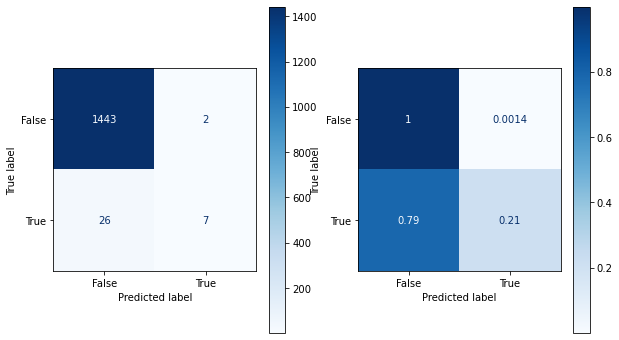

In [126]:
lgbm_pipe = make_pipeline(processor, LGBMClassifier())
lgbm_pipe.fit(X_train, y_train)

metrics = class_eval(lgbm_pipe, 'LightGBM Class ', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

### LightGBM Balanced

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1445
        True       0.56      0.42      0.48        33

    accuracy                           0.98      1478
   macro avg       0.77      0.71      0.74      1478
weighted avg       0.98      0.98      0.98      1478



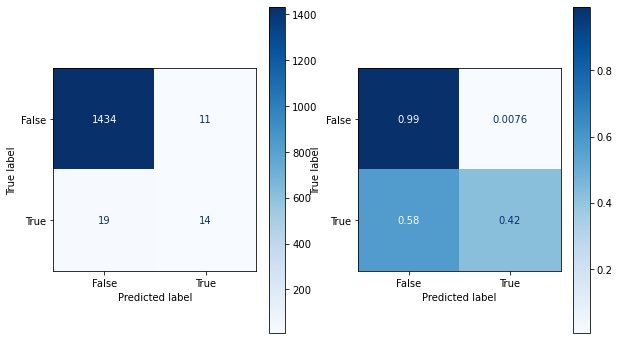

In [127]:
lgbm_balanced = make_pipeline(processor, LGBMClassifier(class_weight = 'balanced'))
lgbm_balanced.fit(X_train, y_train)

metrics = class_eval(lgbm_balanced, 'LightGBM Class Balanced', X_train, X_test, y_train, y_test)
classperformance = classperformance.append(metrics, ignore_index = True)

## Model Performance Overview - Classification

In [128]:
classperformance

,model name,accuracy,roc_auc,precision_min,recall_min,f1-score_min,precision_maj,recall_maj,f1-score_maj
0,K Nearest Neighbor,0.978,0.635,0.500,0.030,0.057,0.978,0.999,0.989
1,Log Reg,0.962,0.859,0.171,0.182,0.176,0.981,0.980,0.981
2,Log Reg Balanced,0.931,0.818,0.178,0.576,0.271,0.990,0.939,0.964
3,Decision Tree,0.967,0.583,0.214,0.182,0.197,0.981,0.985,0.983
4,Decision Tree Balanced,0.962,0.551,0.129,0.121,0.125,0.980,0.981,0.981
5,Bagged Trees Class,0.978,0.778,0.500,0.121,0.195,0.980,0.997,0.989
6,Random Forest,0.978,0.924,0.500,0.061,0.108,0.979,0.999,0.989
7,Random Forest Balanced,0.979,0.915,1.000,0.061,0.114,0.979,1.000,0.989
8,Gradient Boost Class,0.978,0.913,0.538,0.212,0.304,0.982,0.996,0.989
9,XGBoost Class,0.980,0.954,0.636,0.212,0.318,0.982,0.997,0.990


In [129]:
merge_eda = merge_main.copy()

In [130]:
merge_eda.drop(merge_eda.columns[2:133], axis = 1, inplace = True)
merge_eda.head()

,BGGId,name,num_times,avg_rank,Top_100,Top_20,YearPublished,GameWeight,AvgRating,BayesAvgRating,...,Theme_Fashion,Theme_Geocaching,Theme_Ecology,Theme_Chernobyl,Theme_Photography,Theme_French Foreign Legion,Theme_Cruise ships,Theme_Apache Tribes,Theme_Rivers,Theme_Flags identification
0,174430,Gloomhaven,131,1.000,True,True,2017,3.870,8.750,8.515,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,161936,Pandemic Legacy: Season 1,131,2.000,True,True,2015,2.834,8.597,8.445,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,167791,Terraforming Mars,131,3.700,True,True,2016,3.244,8.419,8.274,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,182028,Through the Ages: A New Story of Civilization,131,6.400,True,True,2015,4.414,8.389,8.154,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,12333,Twilight Struggle,131,9.500,True,True,2005,3.591,8.281,8.116,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


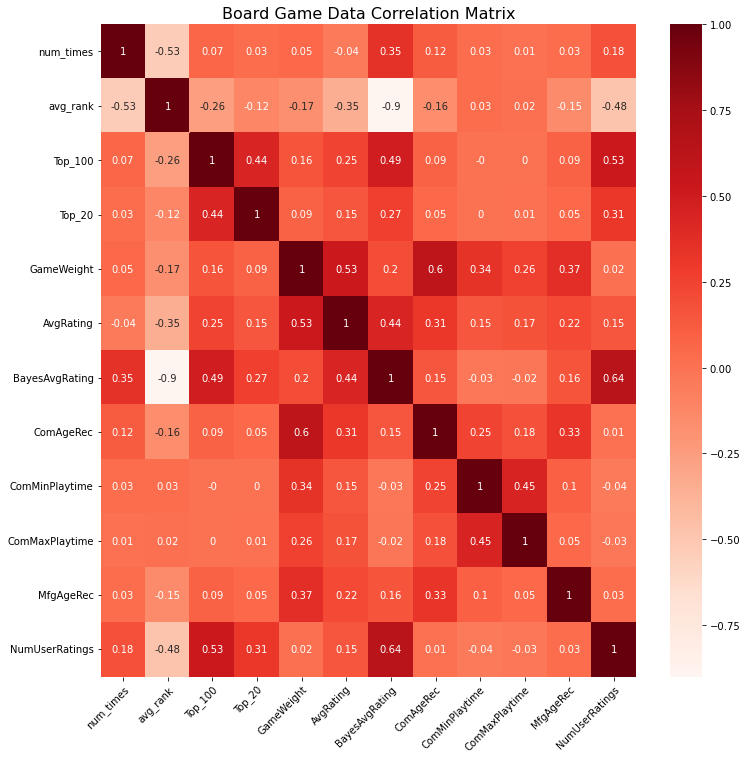

In [131]:
corr_df = merge_eda[merge_eda.columns[2:20]]
corr_df.columns

corr = round(corr_df.drop(columns = ['BestPlayers', 'GoodPlayers', 'YearPublished', 'MinPlayers', 'MaxPlayers', 'MfgPlaytime']).corr(), 2)

fig, ax = plt.subplots(figsize= (12,12))
sns.heatmap(corr, cmap = 'Reds', annot = True, ax = ax)
plt.title('Board Game Data Correlation Matrix', fontsize = 16)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor');

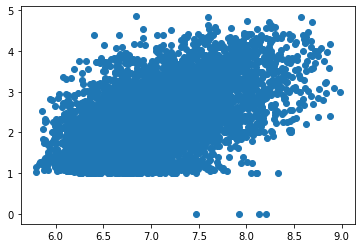

In [132]:
plt.scatter(corr_df['AvgRating'], corr_df['GameWeight']);

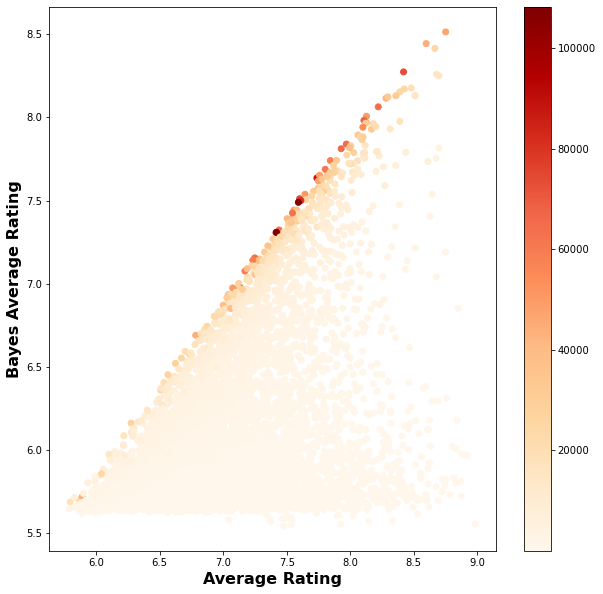

In [133]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(corr_df['AvgRating'], corr_df['BayesAvgRating'], cmap = 'OrRd', c = corr_df['NumUserRatings'], alpha = 1);
plt.colorbar();
plt.xlabel('Average Rating', fontsize = 16, weight = 'semibold')
plt.ylabel('Bayes Average Rating', fontsize = 16, weight = 'semibold');

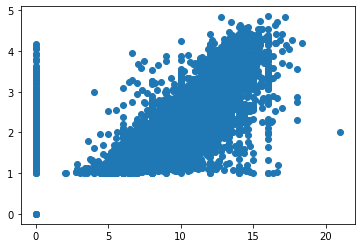

In [134]:
plt.scatter(corr_df['ComAgeRec'], corr_df['GameWeight']);

# Top Feature Graphs

G:\Program Files (x86)\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


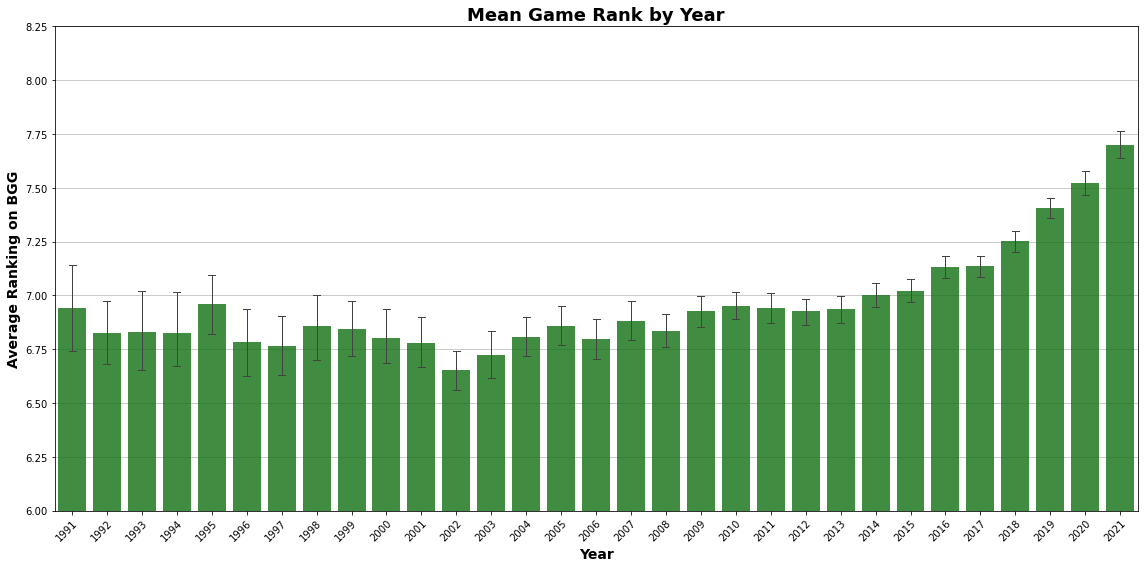

In [135]:
yearmean = merge_ml[merge_ml['YearPublished'] >= 1991]
yearmean['YearPublished']= yearmean['YearPublished'].astype(int)

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = yearmean, x = 'YearPublished', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 1, capsize = .2)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Year', size = 18, weight = 'bold')
plt.xlabel('Year', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();

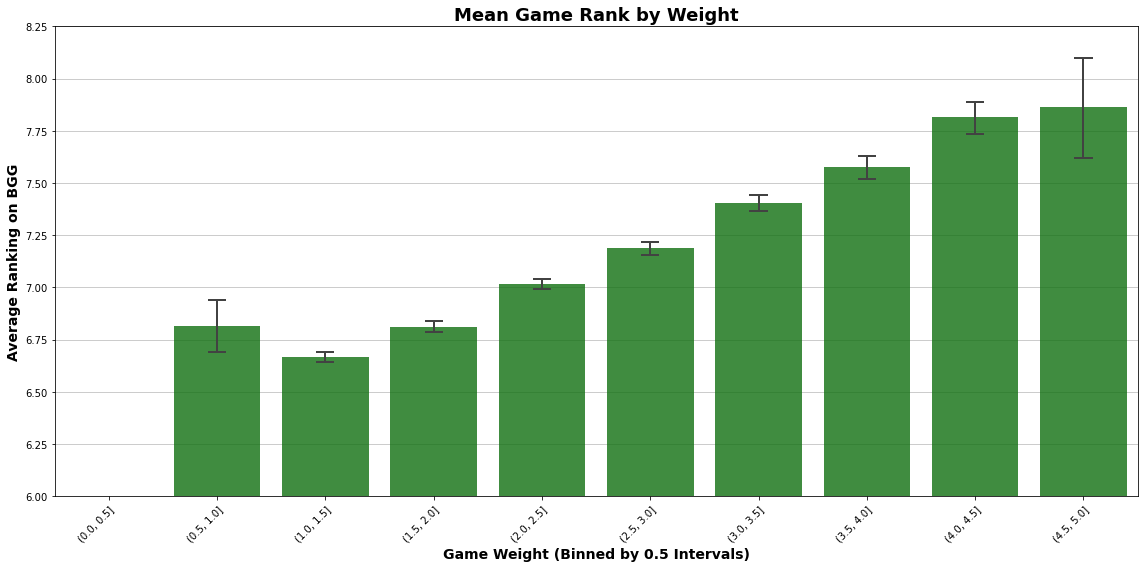

In [136]:
cut_bins2 = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

merge_ml['WeightBin'] = pd.cut(merge_ml['GameWeight'], bins = cut_bins2)

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = merge_ml, x = 'WeightBin', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 2, capsize = .15)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Weight', size = 18, weight = 'bold')
plt.xlabel('Game Weight (Binned by 0.5 Intervals)', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();

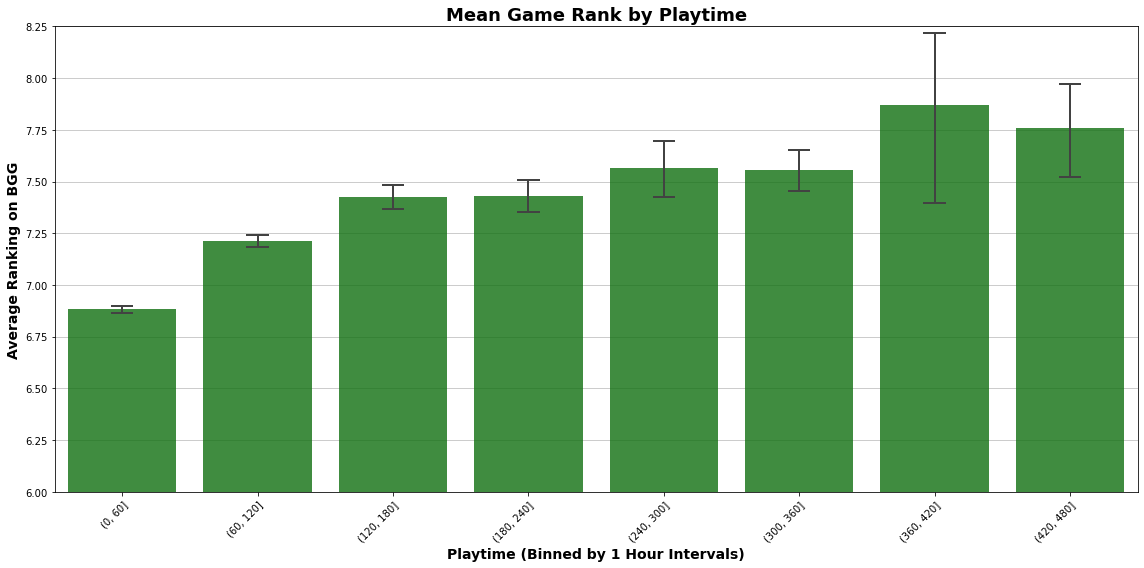

In [137]:
cut_bins2 = range(0, 481, 60)

merge_ml['PlaytimeBin'] = pd.cut(merge_ml['MfgPlaytime'], bins = cut_bins2)

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = merge_ml, x = 'PlaytimeBin', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 2, capsize = .15)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Playtime', size = 18, weight = 'bold')
plt.xlabel('Playtime (Binned by 1 Hour Intervals)', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();

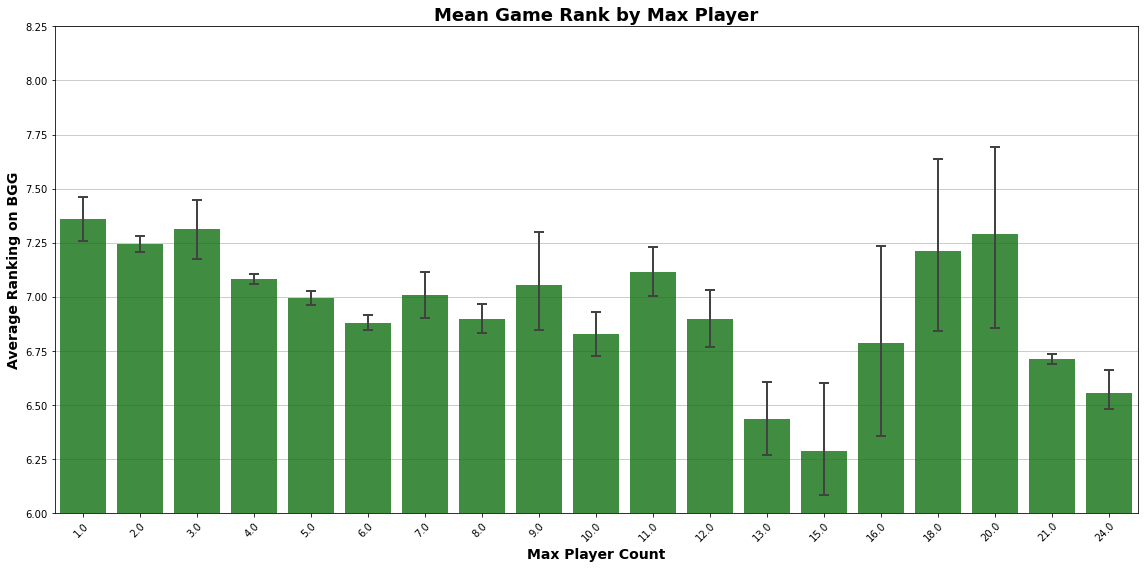

In [138]:
maxplayermean = merge_ml[merge_ml['MaxPlayers'] <= 24]

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = maxplayermean, x = 'MaxPlayers', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 2, capsize = .15)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Max Player', size = 18, weight = 'bold')
plt.xlabel('Max Player Count', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();

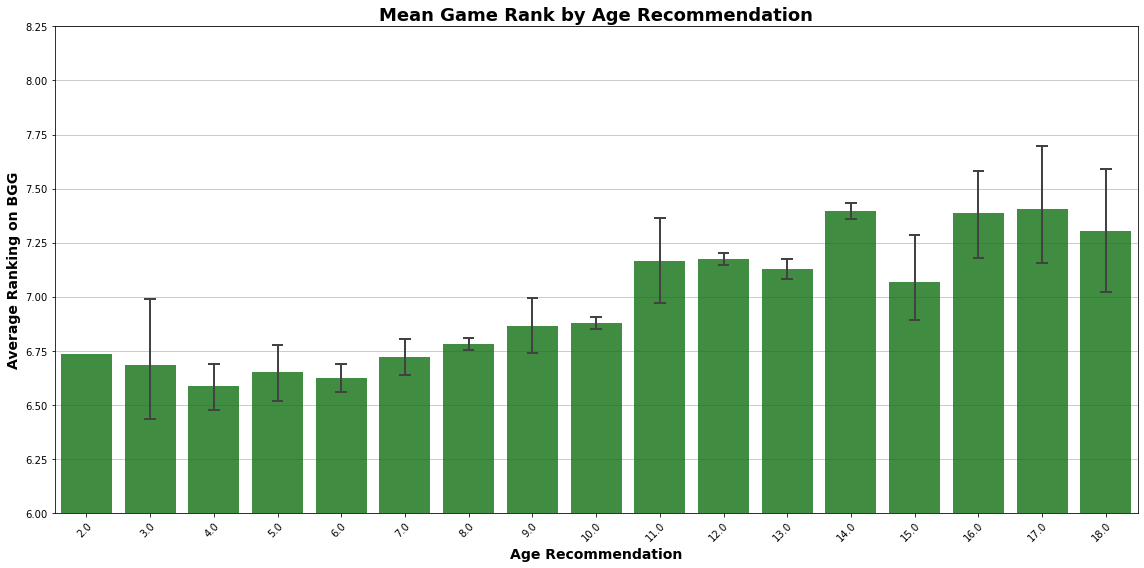

In [139]:
# MfgAgeRec                     10.8

# cut_bins2 = range(0, 481, 30)

# merge_ml['PlaytimeBin'] = pd.cut(merge_ml['MfgPlaytime'], bins = cut_bins2)

# maxplayermean = merge_ml[merge_ml['MaxPlayers'] <= 24]

fig, ax = plt.subplots(figsize = (16, 8))
sns.barplot(data = maxplayermean, x = 'MfgAgeRec', y = 'AvgRating', color = 'Green', estimator=np.mean, alpha = .8, errwidth = 2, capsize = .15)
plt.yticks([6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25])
plt.ylim(6,8.25)
plt.grid(axis = 'y', ls = '-', alpha = .8)
ax.set_axisbelow(True)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.title('Mean Game Rank by Age Recommendation', size = 18, weight = 'bold')
plt.xlabel('Age Recommendation', size = 14, weight = 'semibold')
plt.ylabel('Average Ranking on BGG', size = 14, weight = 'semibold')
plt.tight_layout();


In [140]:
lgbm_importance_df = pd.DataFrame({'feature' :lgbm_importance.index, 'weight' : (lgbm_importance.values/30)})
cat_list = list(merge_ml.columns[merge_ml.columns.str.contains('Cat:')])

lgbm_importance_df[lgbm_importance_df['feature'].isin(cat_list)].sort_values('weight', ascending = False)

,feature,weight
9,Cat:War,1.233
10,Cat:Family,0.800
7,Cat:Thematic,0.700
8,Cat:Strategy,0.700
12,Cat:Abstract,0.267
13,Cat:Party,0.200
11,Cat:CGS,0.167
14,Cat:Childrens,0.000


In [141]:
lgbm_importance_df = pd.DataFrame({'feature' :lgbm_importance.index, 'weight' : (lgbm_importance.values/30)})
subcat_list = list(subcat_long['Subcat'].unique())

lgbm_importance_df[lgbm_importance_df['feature'].isin(subcat_list)].sort_values('weight', ascending = False)

,feature,weight
105,Card Game,1.267
103,Miniatures,1.233
102,Exploration,0.400
111,Electronic,0.267
107,Puzzle,0.200
110,Print & Play,0.200
104,Territory Building,0.133
108,Collectible Components,0.133
106,Educational,0.033
109,Word Game,0.000


In [142]:
lgbm_importance_df = pd.DataFrame({'feature' :lgbm_importance.index, 'weight' : (lgbm_importance.values/30)})
mech_list = list(mech_long['Mechanic'].unique())

lgbm_importance_df[lgbm_importance_df['feature'].isin(mech_list)].sort_values('weight', ascending = False).head(20)

,feature,weight
18,Hand Management,1.400
17,Dice Rolling,1.333
42,Variable Player Powers,1.133
22,Set Collection,0.933
75,Solo / Solitaire Game,0.867
51,Role Playing,0.833
21,Hexagon Grid,0.833
55,Area Movement,0.800
46,Scenario / Mission / Campaign Game,0.800
57,Cooperative Game,0.767


In [143]:
lgbm_importance_df = pd.DataFrame({'feature' :lgbm_importance.index, 'weight' : (lgbm_importance.values/30)})
theme_list = list(theme_long['Theme'].unique())

lgbm_importance_df[lgbm_importance_df['feature'].isin(theme_list)].sort_values('weight', ascending = False).head(20)

,feature,weight
156,Sports,0.900
113,Fantasy,0.833
114,Fighting,0.800
120,Science Fiction,0.600
132,Medieval,0.500
178,Theme_Colonial,0.500
122,Civilization,0.500
155,Humor,0.433
112,Adventure,0.433
123,Civil War,0.400
